In [ ]:
import pandas as pd
import os
import numpy as np
import re

excel_files = [
    '/content/2024 merma bod 321.xlsx',
    '/content/2024 merma isla.xlsx',
    '/content/2023 merma isla.xlsx',
    '/content/2023 merma bod 321.xlsx',
    '/content/2022 merma isla.xlsx',
    '/content/2022 merma bod 321.xlsx'
]


excel_directory = '.'

output_directory = '.'

# celdas donde estan las columnas
col_indices = [7, 10, 13, 16, 19, 21, 24]
col_names = ['Producto', 'Etiqueta', 'Tamaño', 'Color', 'Cajas', 'Kilos', 'Importe_Venta']
header_row_index = 11 # Header esta en la 12

# los nombres de las ventanas de excel
expected_months_sheets = [
    "ENERO", "FEBRERO", "MARZO", "ABRIL", "MAYO", "JUNIO",
    "JULIO", "AGOSTO", "SEPTIEMBRE", "OCTUBRE", "NOVIEMBRE", "DICIEMBRE"
]


# buscamos el año y nombre de la bodega (o isla, pero pos si nos mandan otro archivo de otro lugar igual jalaría)
excel_file_pattern = re.compile(r"(\d{4})\s+merma\s+(isla|bod\s*321)\.xlsx", re.IGNORECASE)

# procesamoe el excel

print("Starting processing of Excel files...")
output_files_generated = []

os.makedirs(output_directory, exist_ok=True)

for file_full_path_or_name in excel_files:
    file_path = os.path.join(excel_directory, file_full_path_or_name)

    excel_file_name = os.path.basename(file_path)

    print(f"\nProcessing file: {excel_file_name} (from path: {file_path})")

    if not os.path.exists(file_path):
        print(f"  ERROR: File not found at {file_path}. Skipping.😢")
        continue

    match = excel_file_pattern.match(excel_file_name)
    if not match:
        print(f"  WARNING: Could not parse filename '{excel_file_name}' for Year/Source. Skipping.")
        continue

    year = int(match.group(1))
    source_raw = match.group(2)
    source = 'bod' if 'bod' in source_raw.lower() else 'isla'

    all_sheets_data = []

    try:
        excel_data = pd.read_excel(file_path, sheet_name=None, header=header_row_index, engine='openpyxl')

        # Itera sobre las pestañitas
        for sheet_name, df_sheet in excel_data.items():
            month = sheet_name.strip().capitalize()
            month_upper = sheet_name.strip().upper()

            print(f"  Reading sheet: '{sheet_name}' -> Month: {month}")

            try:
                 if len(df_sheet.columns) > max(col_indices):
                     df_processed = df_sheet.iloc[:, col_indices].copy()
                     df_processed.columns = col_names
                 else:
                      print(f"  ERROR: Sheet '{sheet_name}' in {excel_file_name} has fewer columns ({len(df_sheet.columns)}) than expected index ({max(col_indices)}). Skipping sheet.")
                      continue
            except IndexError:
                 print(f"  ERROR: Could not select columns by index for sheet '{sheet_name}' in {excel_file_name}. Skipping sheet.")
                 continue
            except Exception as e_col:
                 print(f"  ERROR processing columns for sheet '{sheet_name}' in {excel_file_name}: {e_col}. Skipping sheet.")
                 continue

            df_processed.dropna(subset=['Producto'], inplace=True)

            if not df_processed.empty:
                df_processed['Year'] = year
                df_processed['Month'] = month
                df_processed['Source'] = source
                all_sheets_data.append(df_processed)
            else:
                print(f"  INFO: No data rows found in sheet '{sheet_name}' after dropping NaNs.")

        # Combina la data anterior
        if all_sheets_data:
            combined_year_source_df = pd.concat(all_sheets_data, ignore_index=True) #tirar el index
            print(f"  -> Combined {len(all_sheets_data)} sheets for {year}-{source}.")

            numeric_cols = ['Cajas', 'Kilos', 'Importe_Venta']
            for col in numeric_cols:
                if col in combined_year_source_df.columns:
                    if combined_year_source_df[col].dtype == 'object':
                       combined_year_source_df[col] = combined_year_source_df[col].astype(str).str.replace(',', '', regex=False)
                    combined_year_source_df[col] = pd.to_numeric(combined_year_source_df[col], errors='coerce')
                    combined_year_source_df[col] = combined_year_source_df[col].fillna(0)
                    if col == 'Cajas':
                        combined_year_source_df[col] = combined_year_source_df[col].astype(int)

            text_cols = ['Producto', 'Etiqueta', 'Tamaño', 'Color']
            try:
                for col in text_cols:
                    if col in combined_year_source_df.columns:
                        if combined_year_source_df[col].dtype == 'object':
                            temp_series = combined_year_source_df[col].astype(str)

                            temp_series = temp_series.str.replace('Ã±', 'ñ', regex=False).str.replace('Ã‘', 'Ñ', regex=False)
                            temp_series = temp_series.str.replace('Ã¡', 'á', regex=False).str.replace('Ã©', 'é', regex=False)

                            combined_year_source_df[col] = temp_series
            except Exception as e_enc:
                print(f"  Warning: Error during encoding correction for {excel_file_name}: {e_enc}")

            cols_order = ['Year', 'Month', 'Source'] + col_names
            final_cols_order = [col for col in cols_order if col in combined_year_source_df.columns]
            extra_cols = [col for col in combined_year_source_df.columns if col not in final_cols_order]
            combined_year_source_df = combined_year_source_df[final_cols_order + extra_cols]


            #guardarlo
            output_filename = os.path.join(output_directory, f"merma_{year}_{source}.csv")
            try:
                # Sort antes de guardar para que se vea bonito (no necesary)
                month_order_map = {
                    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
                    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
                }

                combined_year_source_df['Month_Num'] = combined_year_source_df['Month'].str.capitalize().map(month_order_map)
                combined_year_source_df_sorted = combined_year_source_df.sort_values(by=['Month_Num', 'Producto'])
                combined_year_source_df_sorted = combined_year_source_df_sorted.drop(columns=['Month_Num'])

                combined_year_source_df_sorted.to_csv(output_filename, index=False, encoding='utf-8-sig')
                print(f"  -> Saved combined data to: {output_filename} ({len(combined_year_source_df_sorted)} rows)")
                output_files_generated.append(output_filename)
            except Exception as e_save:
                print(f"  ERROR saving file {output_filename}: {e_save}")

        else:
            print(f"  -> No valid data found in any sheet for {excel_file_name}.")

    except Exception as e_excel:
        print(f"  ERROR processing Excel file {excel_file_name}: {e_excel}")


print(f"\nProcessing finished. Generated {len(output_files_generated)} CSV files:")
for fname in output_files_generated:
    print(f"- {fname}")

Starting processing of Excel files...

Processing file: 2024 merma bod 321.xlsx (from path: /content/2024 merma bod 321.xlsx)
  Reading sheet: 'enero ' -> Month: Enero
  Reading sheet: 'febrero' -> Month: Febrero
  Reading sheet: 'marzo' -> Month: Marzo
  Reading sheet: 'abril' -> Month: Abril
  Reading sheet: 'mayo' -> Month: Mayo
  Reading sheet: 'junio' -> Month: Junio
  Reading sheet: 'julio' -> Month: Julio
  Reading sheet: 'agosto' -> Month: Agosto
  Reading sheet: 'septiembre' -> Month: Septiembre
  Reading sheet: 'octubre' -> Month: Octubre
  Reading sheet: 'noviembre' -> Month: Noviembre
  Reading sheet: 'diciembre' -> Month: Diciembre
  -> Combined 12 sheets for 2024-bod.
  -> Saved combined data to: ./merma_2024_bod.csv (942 rows)

Processing file: 2024 merma isla.xlsx (from path: /content/2024 merma isla.xlsx)
  Reading sheet: 'enero' -> Month: Enero
  Reading sheet: 'febrero' -> Month: Febrero
  Reading sheet: 'marzo' -> Month: Marzo
  Reading sheet: 'abril' -> Month: Abri

In [ ]:
import pandas as pd
import os
#mejor voy a comentar en español
#btw esto es porque estoy en colab
data_dir = '/content/'


bod_files_to_combine = [
    os.path.join(data_dir, 'merma_2024_bod.csv'),
    os.path.join(data_dir, 'merma_2023_bod.csv'),
    os.path.join(data_dir, 'merma_2022_bod.csv')
]


list_of_bod_dataframes = []

# --- Proceso para archivos 'bod' ---
print("Procesando archivos 'bod'...")
# itera sobre la lista de archivos, lee cada uno y añade a la lista
for file_path in bod_files_to_combine:
    try:

        df_temp = pd.read_csv(file_path)

        list_of_bod_dataframes.append(df_temp)
        print(f"  - Archivo leído correctamente: {file_path} ({len(df_temp)} filas)")
    except FileNotFoundError:
        print(f"  - Advertencia! Archivo no encontrado: {file_path}. Se omitirá.")
    except Exception as e:
        print(f"  - Error! No se pudo leer el archivo {file_path}: {e}. Se omitirá.")


if list_of_bod_dataframes:
    # Concatena todos los df's de la lista en uno solo
    # ignore_index=True reinicia el índice del df combinado similar que arriba
    df_bod_combinado = pd.concat(list_of_bod_dataframes, ignore_index=True)

    print(f"\nDataFrame 'bod' combinado creado con éxito. Total de filas: {len(df_bod_combinado)}")

    # Define el nombre del archivo csv de salida para 'bod' (esto hay que cambiarlo para hacerlo mas general y no copiar y pegar como le hice)
    output_bod_csv_path = os.path.join(data_dir, 'merma_bod_combinado_2022-2024.csv')

    #guardar el df combinado en un nuevo archivo csv
    # index=False evita que pandas escriba el índice del df como una columna en el csv igual que arriba
    try:
        df_bod_combinado.to_csv(output_bod_csv_path, index=False, encoding='utf-8-sig') # utf-8-sig es bueno para compatibilidad con excel las eñes sobre todo
        print(f"df 'bod' combinado guardado como: {output_bod_csv_path}")
    except Exception as e:
        print(f"error! No se pudo guardar el archivo csv combinado para 'bod': {e}")

    # Ahora tenemos el df 'df_bod_combinado'
    # las primeras 5 filas
    print("\nPrimeras 5 filas del df 'bod' combinado:")
    print(df_bod_combinado.head())

else:
    print("\nNo se pudo leer ningún archivo 'bod'. No se generó ningún df ni archivo csv combinado.")

# copié y pegué para isla

print("\n------------------------------------------")
print("Procesando archivos 'isla'...")

isla_files_to_combine = [
    os.path.join(data_dir, 'merma_2024_isla.csv'),
    os.path.join(data_dir, 'merma_2023_isla.csv'),
    os.path.join(data_dir, 'merma_2022_isla.csv')
]
list_of_isla_dataframes = []

for file_path in isla_files_to_combine:
    try:
        df_temp = pd.read_csv(file_path)
        list_of_isla_dataframes.append(df_temp)
        print(f"  - Archivo leído correctamente: {file_path} ({len(df_temp)} filas)")
    except FileNotFoundError:
        print(f"  - ¡Advertencia! Archivo no encontrado: {file_path}. Se omitirá.")
    except Exception as e:
        print(f"  - ¡Error! No se pudo leer el archivo {file_path}: {e}. Se omitirá.")

if list_of_isla_dataframes:
    df_isla_combinado = pd.concat(list_of_isla_dataframes, ignore_index=True)
    print(f"\df 'isla' combinado creado con éxito. Total de filas: {len(df_isla_combinado)}")
    output_isla_csv_path = os.path.join(data_dir, 'merma_isla_combinado_2022-2024.csv')
    try:
        df_isla_combinado.to_csv(output_isla_csv_path, index=False, encoding='utf-8-sig')
        print(f"df 'isla' combinado guardado como: {output_isla_csv_path}")
        print("\nPrimeras 5 filas del DataFrame 'isla' combinado:")
        print(df_isla_combinado.head())
    except Exception as e:
        print(f"error! No se pudo guardar el archivo csv combinado para 'isla': {e}")
else:
    print("\nNo se pudo leer ningún archivo 'isla'. No se generó ningún df ni archivo csv combinado.")

Procesando archivos 'bod'...
  - Archivo leído correctamente: /content/merma_2024_bod.csv (942 filas)
  - Archivo leído correctamente: /content/merma_2023_bod.csv (1098 filas)
  - Archivo leído correctamente: /content/merma_2022_bod.csv (876 filas)

DataFrame 'bod' combinado creado con éxito. Total de filas: 2916
df 'bod' combinado guardado como: /content/merma_bod_combinado_2022-2024.csv

Primeras 5 filas del df 'bod' combinado:
   Year  Month Source  Producto      Etiqueta    Tamaño Color  Cajas  Kilos  \
0  2024  Enero    bod  Cebolla   SIN ETIQUETA  JB SELEC   NaN      5   52.5   
1  2024  Enero    bod  Cebolla   SIN ETIQUETA    LG SEL   NaN      8   80.0   
2  2024  Enero    bod  Cebolla   SIN ETIQUETA    LM MEX   NaN      0    5.0   
3  2024  Enero    bod  Cebolla   SIN ETIQUETA  LM SELEC   NaN      2   19.0   
4  2024  Enero    bod  Cebolla   SIN ETIQUETA  PP SELEC   NaN      0   19.0   

   Importe_Venta  
0            0.0  
1            0.0  
2            0.0  
3            0.

Merma Total (Kilos) por Producto (Top 10):
| Producto           | Kilos   |
|:-------------------|:--------|
| Tomatillo          | 12443.7 |
| Jalapeño           | 12053.9 |
| Cebolla            | 11495.9 |
| Serrano            | 2346.06 |
| Cebolla Morada     | 1427.49 |
| Jalapeño Rojo      | 1131    |
| Cebolla amarilla   | 391.5   |
| jalapeño chocolate | 217.9   |
| Ajo kgs            | 210.85  |
| Poblano            | 13.5    |

Se modelarán los siguientes 10 productos principales: Tomatillo, Jalapeño, Cebolla , Serrano, Cebolla Morada, Jalapeño Rojo, Cebolla amarilla, jalapeño chocolate , Ajo kgs, Poblano

--- Entrenando modelo SARIMA para: Tomatillo ---
Predicción SARIMA para Tomatillo (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 1031.53 | 0            | 2647.4       |
| 2025-02-01 00:00:00 | 3406.14 | 1818.96      | 4993.32      |


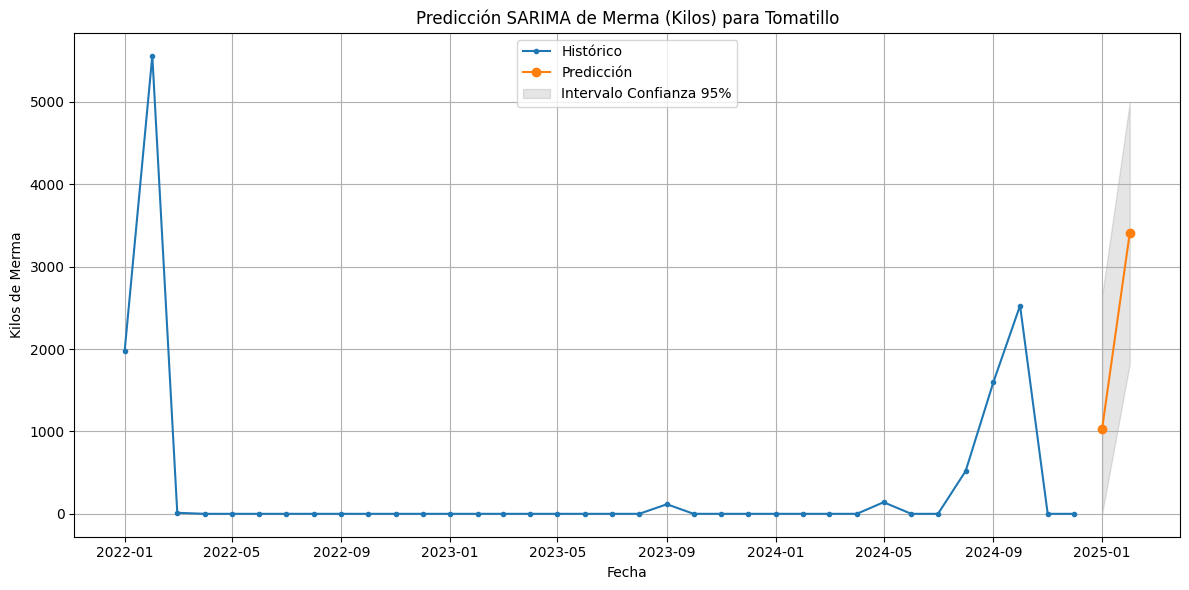


--- Entrenando modelo SARIMA para: Jalapeño ---
Predicción SARIMA para Jalapeño (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 170.163 | 0            | 1539.27      |
| 2025-02-01 00:00:00 | 0       | 0            | 1175.11      |


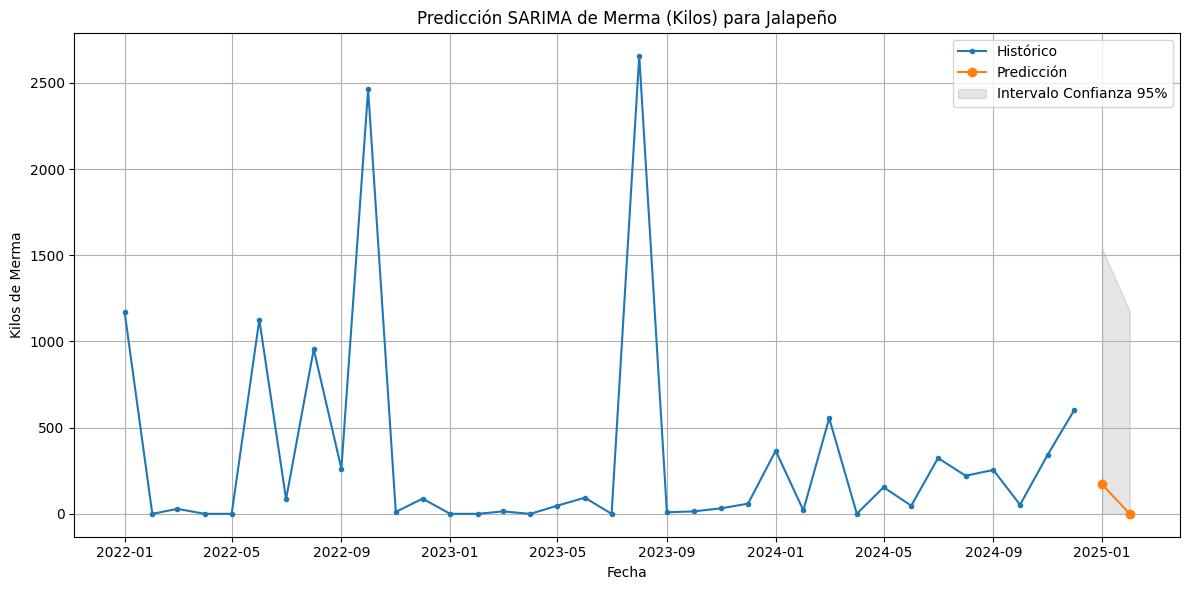


--- Entrenando modelo SARIMA para: Cebolla  ---
Predicción SARIMA para Cebolla  (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 227.762 | 0            | 682.263      |
| 2025-02-01 00:00:00 | 186.668 | 0            | 641.821      |


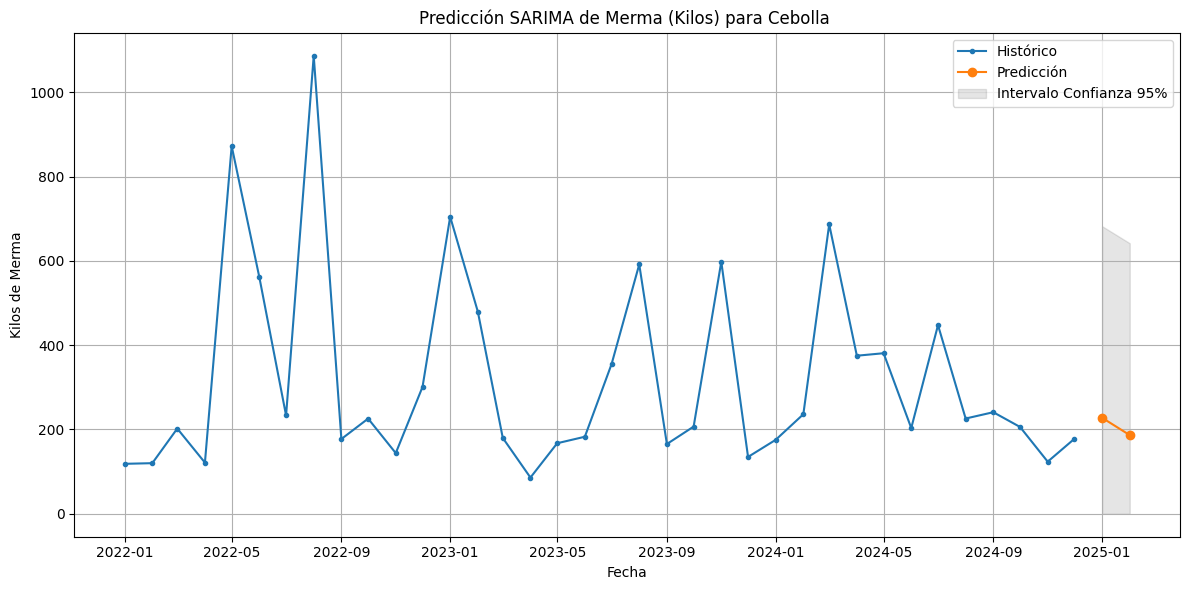


--- Entrenando modelo SARIMA para: Serrano ---
Predicción SARIMA para Serrano (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 359.692 | 0            | 1002.97      |
| 2025-02-01 00:00:00 | 312.648 | 0            | 942.1        |


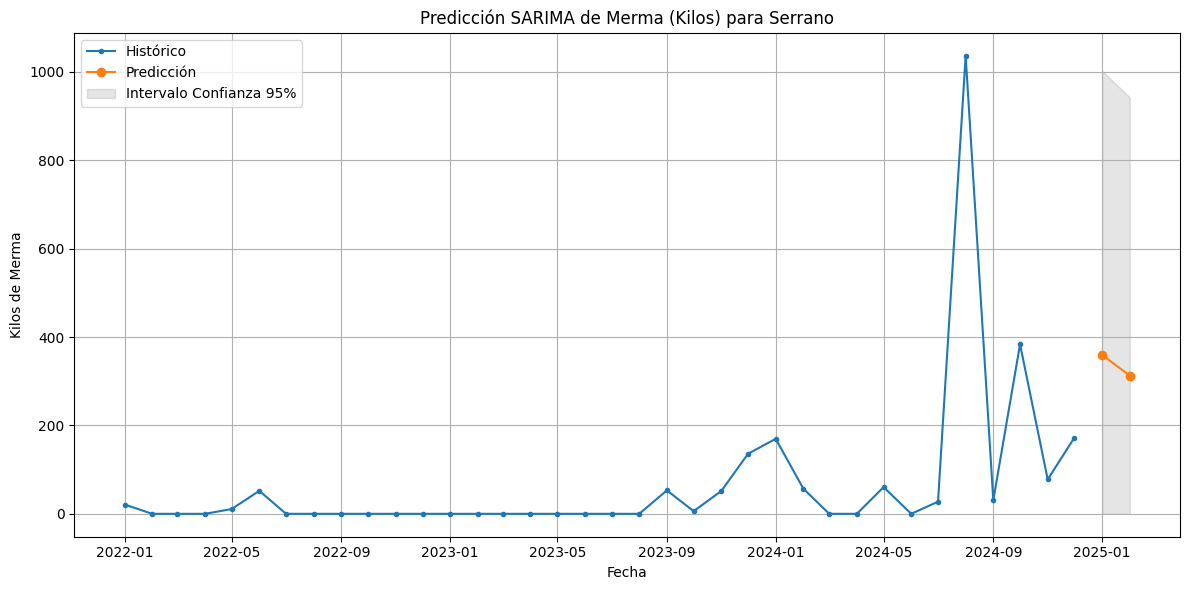


--- Entrenando modelo SARIMA para: Cebolla Morada ---
Predicción SARIMA para Cebolla Morada (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 73.0011 | 35.1204      | 110.882      |
| 2025-02-01 00:00:00 | 66.546  | 29.232       | 103.86       |


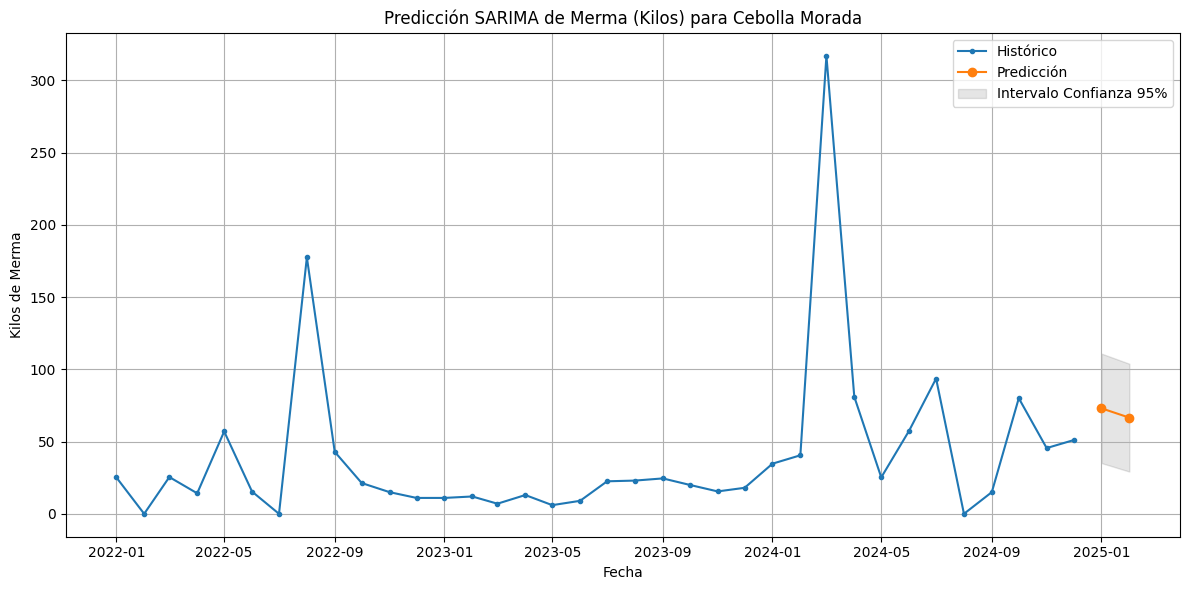


--- Entrenando modelo SARIMA para: Jalapeño Rojo ---
Predicción SARIMA para Jalapeño Rojo (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 308.545 | 0            | 809.875      |
| 2025-02-01 00:00:00 | 303.609 | 0            | 809.846      |


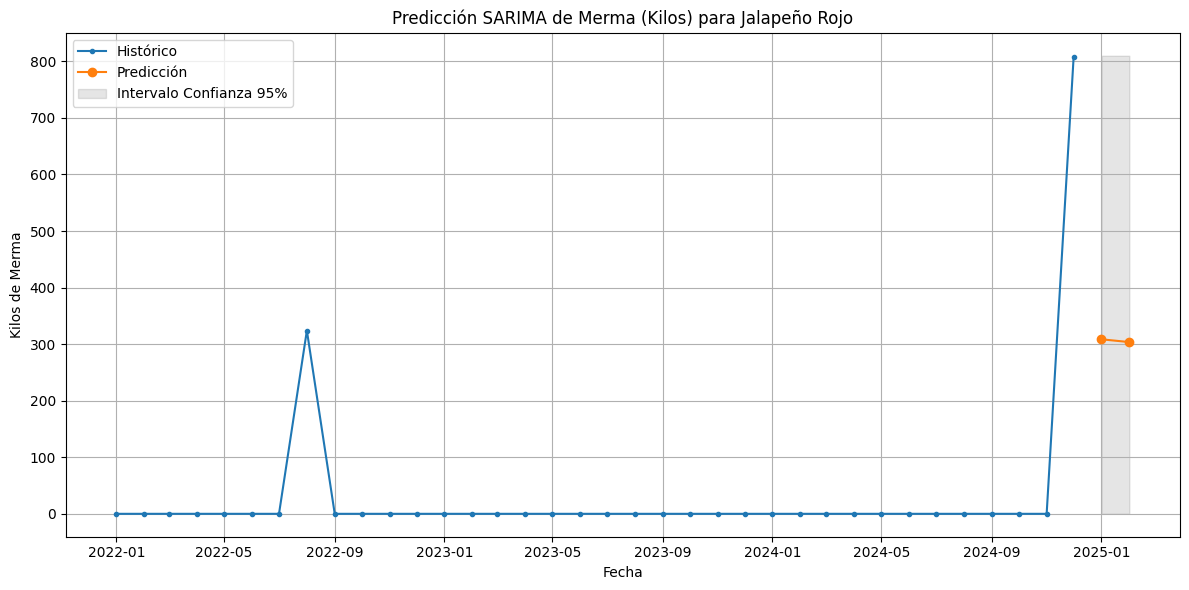


--- Entrenando modelo SARIMA para: Cebolla amarilla ---
Predicción SARIMA para Cebolla amarilla (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 12.6372 | 0            | 47.9444      |
| 2025-02-01 00:00:00 | 91.1337 | 55.8172      | 126.45       |


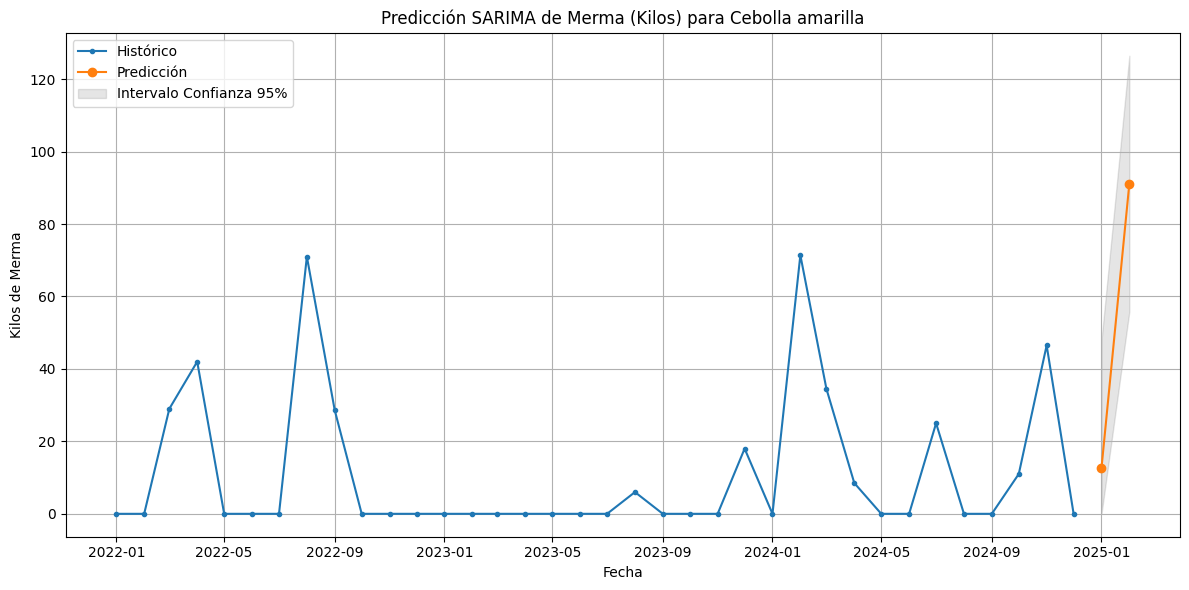


--- Entrenando modelo SARIMA para: jalapeño chocolate  ---
Predicción SARIMA para jalapeño chocolate  (próximos 2 meses):
| ds                  | yhat        | yhat_lower   | yhat_upper   |
|:--------------------|:------------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 0.000333846 | 0            | 0.00240868   |
| 2025-02-01 00:00:00 | 0.000647751 | 0            | 0.00349562   |


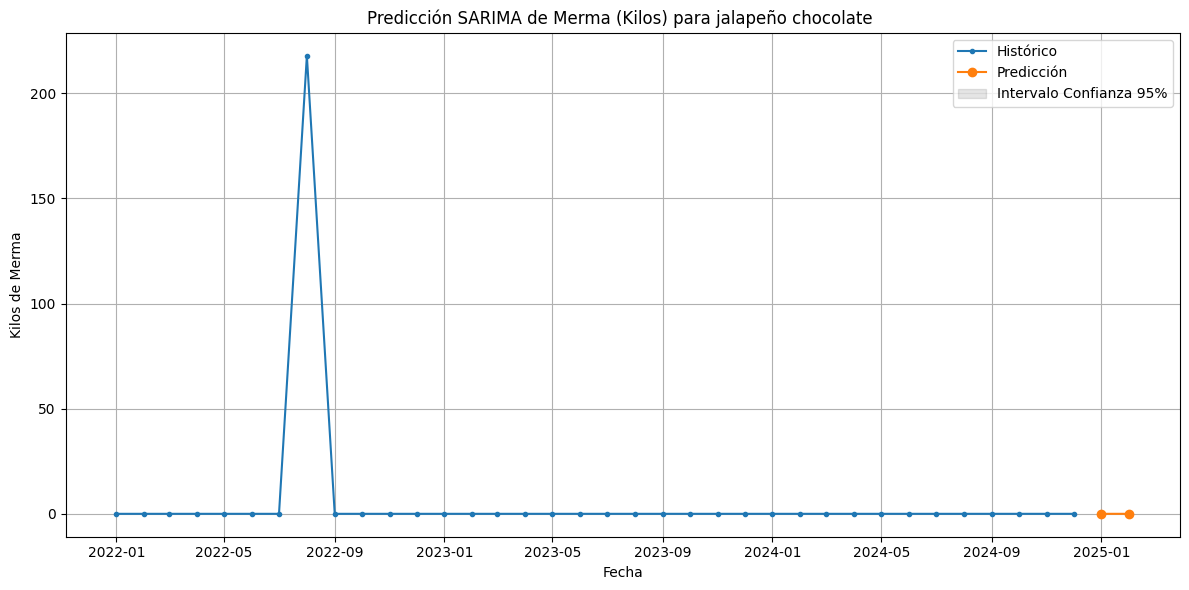


--- Entrenando modelo SARIMA para: Ajo kgs ---
Predicción SARIMA para Ajo kgs (próximos 2 meses):
| ds                  | yhat     | yhat_lower   | yhat_upper   |
|:--------------------|:---------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 0.731027 | 0            | 10.4694      |
| 2025-02-01 00:00:00 | 1.16047  | 0            | 19.6551      |


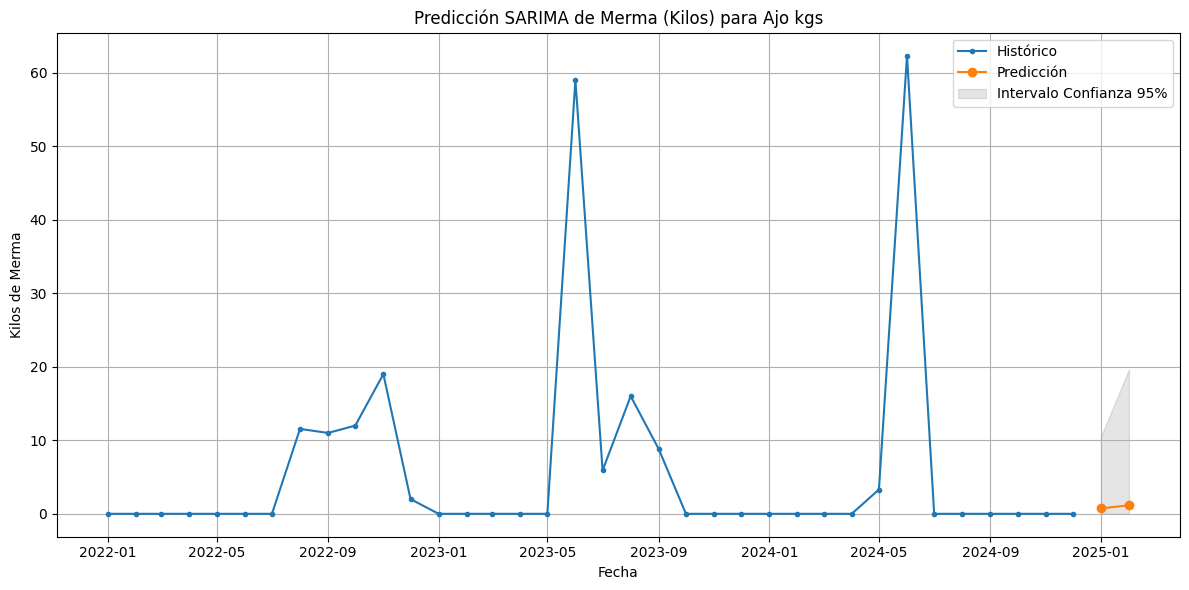


--- Entrenando modelo SARIMA para: Poblano ---
Predicción SARIMA para Poblano (próximos 2 meses):
| ds                  | yhat        | yhat_lower   | yhat_upper   |
|:--------------------|:------------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 7.74387e-05 | 0            | 0.000326789  |
| 2025-02-01 00:00:00 | 0.000163095 | 0            | 0.000535121  |


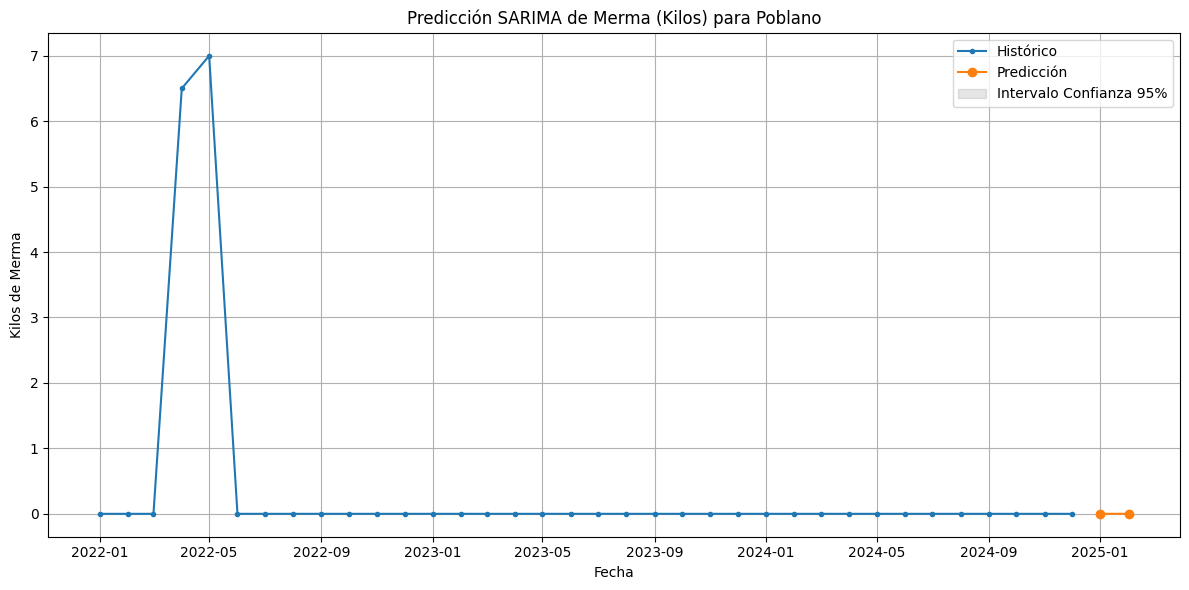


--- Resumen de Predicciones SARIMA (Próximos 3 Meses) ---
| Producto           | Fecha               | Prediccion_Kilos   | yhat_lower   | yhat_upper   |
|:-------------------|:--------------------|:-------------------|:-------------|:-------------|
| Tomatillo          | 2025-01-01 00:00:00 | 1031.53            | 0            | 2647.4       |
| Tomatillo          | 2025-02-01 00:00:00 | 3406.14            | 1818.96      | 4993.32      |
| Jalapeño           | 2025-01-01 00:00:00 | 170.163            | 0            | 1539.27      |
| Jalapeño           | 2025-02-01 00:00:00 | 0                  | 0            | 1175.11      |
| Cebolla            | 2025-01-01 00:00:00 | 227.762            | 0            | 682.263      |
| Cebolla            | 2025-02-01 00:00:00 | 186.668            | 0            | 641.821      |
| Serrano            | 2025-01-01 00:00:00 | 359.692            | 0            | 1002.97      |
| Serrano            | 2025-02-01 00:00:00 | 312.648            | 0          

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ignorar advertencias comunes de statsmodels esto se lo pedí a chatgpt porque salian muchos errores
import warnings
warnings.filterwarnings("ignore")


file_name = "/content/merma_bod_combinado_2022-2024.csv"


df = pd.read_csv(file_name)

month_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df['Month_Num'] = df['Month'].map(month_map)

# generar columna de fecha (usando el primer día del mes)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int) # imputar NaNs como 0 y convertir a int
df = df[df['Month_Num'] != 0] # borra filas donde el mes no se pudo mapear
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- Promedio historíco de temperaturas ---
# promedios históricos de temperatura media mensual en Fahrenheit (de timeanddate.com)
# ya que no tenemos nada más que la merma, de lo que nos podemos ayudar es de algún factor externo como la humedad relativa, mm de precipitación, o temperatura, yo ahorita agarré temperatura para ver si tiene alguna correlación entre merma y temperatura (pensando que a mayor temperatura las frutas duran menos, pero el pensamiento se puede extrapolar con otras condiciones incluso microeconómicas como el precio del producto o de la gasolina, etc.)
temp_f = {
    1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85,
    7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61
}
# Convertir a Celsius: C = (F - 32) * 5/9 gracias al buen chatgpt
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}

temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])


# agregarndo por fecha y producto
df_product_monthly = df.groupby(['Date', 'Producto'])['Kilos'].sum().reset_index()

# calculando merma total por producto para identificar los más importantes
total_spoilage_per_product = df_product_monthly.groupby('Producto')['Kilos'].sum().sort_values(ascending=False)

top_n = 10

print(f"Merma Total (Kilos) por Producto (Top {top_n}):")
print(total_spoilage_per_product.head(top_n).to_markdown(numalign="left", stralign="left"))

# tomamos los N productos principales para modelar (ej. Top 10 (todos))

top_products = total_spoilage_per_product.head(top_n).index.tolist()
print(f"\nSe modelarán los siguientes {top_n} productos principales: {', '.join(top_products)}")

all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, top_products], names=['Date', 'Producto'])

# reindexar y llenar con 0 los kilos faltantes
df_model_data = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()

# añadir la columna de temperatura promedio histórica
df_model_data['Month_Num'] = df_model_data['Date'].dt.month
df_model_data = pd.merge(df_model_data, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# renombrar columnas clave ('Date' -> 'ds', 'Kilos' -> 'y') para mejor claridad (lo vi en un blog, después se los paso)
df_model_data = df_model_data.rename(columns={'Date': 'ds', 'Kilos': 'y'})

n_forecast_periods = 2 # dos meses (porque pos todo está en meses, pero podemos poner a 6 o 12, los que sean, la idea es que esto se corra diario o casi diario para que se pueda ir actualizando esta predicción)
last_date = df_model_data['ds'].max()
future_dates_sarima = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast_periods, freq='MS')

# el problema es que también se tiene que hacerse para las temperaturas futuras 🤷‍♂️
future_temp_df = pd.DataFrame({'ds': future_dates_sarima})
future_temp_df['Month_Num'] = future_temp_df['ds'].dt.month
# usando el mismo nombre de columna 'temp' que en los datos históricos
future_temp_df = pd.merge(future_temp_df, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# selecc solo la columna 'temp' como DataFrame y asegurar que no haya NaNs
future_exog = future_temp_df[['temp']] # Extraer como DataFrame
# rellenar NaNs si los hubiera (poco probable aquí, no vi la neta) con la media global histórica
if future_exog.isnull().values.any():
    mean_hist_temp = df_model_data['temp'].mean() # Calcular media de la columna 'temp' histórica
    print(f"Advertencia: Rellenando NaNs en temperaturas futuras con la media histórica ({mean_hist_temp:.1f}°C).")
    future_exog = future_exog.fillna(mean_hist_temp)

# SARIMA
forecasts_sarima = {}
models_sarima = {}

# entrenar el modelo y predecir para cada producto principal (que decidimos arriba ej 10)
for product in top_products:
    print(f"\n--- Entrenando modelo SARIMA para: {product} ---")
    # Filtrar datos para el producto actual
    product_data_sarima = df_model_data[df_model_data['Producto'] == product][['ds', 'y', 'temp']].copy()
    product_data_sarima = product_data_sarima.set_index('ds').sort_index()

    # separar variable endógena (y) y exógena (temp)
    endog = product_data_sarima['y']
    # asegurarse que exog sea un df con la columna 'temp'
    exog = product_data_sarima[['temp']] #por eso las dos brackets

    #rellenar NaNs en exog histórico si existen (poco probable)
    if exog.isnull().values.any():
         mean_prod_temp = exog['temp'].mean()
         print(f"Advertencia: Rellenando NaNs en la temperatura histórica para {product} con su media ({mean_prod_temp:.1f}°C).")
         exog = exog.fillna(mean_prod_temp)

    #verificar si hay suficientes datos
    if len(endog) < 24: # SARIMA a menudo necesita al menos 2 ciclos estacionales segun dicen
        print(f"Datos insuficientes (<24 meses) para modelar {product} con SARIMA. Saltando...")
        continue

    # Definir órdenes SARIMA (ejemplo: (0,1,1)x(0,1,1,12))
    # Esto es una heurística común, la optimización requeriría más análisis (ACF/PACF, grid search)
    order = (0, 1, 1) # (p, d, q)
    seasonal_order = (0, 1, 1, 12) # (P, D, Q, s=12 meses)

    try:
        # instanciar y entrenar el modelo SARIMAX
        model = SARIMAX(endog=endog,
                        exog=exog, # Pasar DataFrame histórico
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        trend='c') # 'c' = constante/intercepto

        results = model.fit(disp=False) # disp=False para menos output
        models_sarima[product] = results

        #realizar la predicción para los próximos 2 meses (esto lo pusimos en n_forecast_periods)
        # pasar el DataFrame future_exog que contiene la columna 'temp'
        forecast_obj = results.get_forecast(steps=n_forecast_periods, exog=future_exog.head(n_forecast_periods))
        forecast_values = forecast_obj.predicted_mean
        forecast_ci = forecast_obj.conf_int(alpha=0.05) # Intervalo de confianza del 95%

        # guardar predicción
        forecast_df = pd.DataFrame({
            'ds': future_dates_sarima,
            'yhat': forecast_values.values,
            'yhat_lower': forecast_ci.iloc[:, 0].values,
            'yhat_upper': forecast_ci.iloc[:, 1].values
        })
        #Asegurar que la merma no sea negativa
        forecast_df[['yhat', 'yhat_lower', 'yhat_upper']] = forecast_df[['yhat', 'yhat_lower', 'yhat_upper']].clip(lower=0)

        forecasts_sarima[product] = forecast_df

        print(f"Predicción SARIMA para {product} (próximos {n_forecast_periods} meses):")
        print(forecast_df.to_markdown(index=False, numalign="left", stralign="left"))

        #graficas
        plt.figure(figsize=(12, 6))
        plt.plot(endog.index, endog, label='Histórico', marker='.')
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Predicción', marker='o')
        plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'],
                         color='k', alpha=0.1, label='Intervalo Confianza 95%')
        plt.title(f'Predicción SARIMA de Merma (Kilos) para {product}')
        plt.xlabel('Fecha')
        plt.ylabel('Kilos de Merma')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al entrenar el modelo SARIMA para {product}: {e}")

#resumen
all_forecasts_list = []
for product, forecast_df in forecasts_sarima.items():
    forecast_df['Producto'] = product
    all_forecasts_list.append(forecast_df)

if all_forecasts_list:
    final_forecast_summary = pd.concat(all_forecasts_list)
    print("\n--- Resumen de Predicciones SARIMA (Próximos 3 Meses) ---")
    print(final_forecast_summary[['Producto', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Fecha', 'yhat': 'Prediccion_Kilos'}).to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("\nNo se pudieron generar predicciones SARIMA para los productos seleccionados.")

# analizar significancia del regresor de temperatura ---

print("\n--- Resumen Estadístico de los Modelos SARIMA ---")
print("Busca la fila 'temp' y verifica su coeficiente ('coef') y P-valor ('P>|z|').")
print("Un P-valor < 0.05 sugiere que la temperatura es un predictor significativo para ese producto.\n")

if not models_sarima:
    print("No se encontraron modelos SARIMA entrenados en la memoria.")
    print("Por favor, asegúrate de haber ejecutado el script de entrenamiento primero.")
else:
    for product, results in models_sarima.items():
        print(f"\n--- Resumen para: {product} ---")
        try:
            # Imprimir el resumen completo del modelo
            print(results.summary())
        except Exception as e:
            print(f"No se pudo obtener el resumen para {product}: {e}")

print("\n--- Fin del Análisis de Significancia ---")









Tomatillo: temp P>|z| = 1.000 (No significativo)

Jalapeño: temp P>|z| = 0.968 (No significativo)

Cebolla: temp P>|z| = 0.996 (No significativo)

Serrano: temp P>|z| = 1.000 (No significativo)

Cebolla Morada: temp P>|z| = 1.000 (No significativo)

Jalapeño Rojo: temp P>|z| = 1.000 (No significativo) - Además, la predicción para febrero 2025 parece extremadamente alta, lo que podría indicar un problema con este modelo específico.

Cebolla amarilla: temp P>|z| = 1.000 (No significativo)

jalapeño chocolate: temp P>|z| = 0.000 (Significativo!) - El coeficiente es -0.0071, lo que sugiere que, para este producto, una mayor temperatura se asocia con una ligera disminución en la merma, según el modelo.

Ajo kgs: temp P>|z| = 1.000 (No significativo)

Poblano: temp P>|z| = 0.000 (Significativo!) - El coeficiente es positivo pero extremadamente pequeño (1.558e-09), casi cero. Aunque estadísticamente significativo, el impacto práctico de la temperatura en la merma del poblano parece ser insignificante según este modelo.

Además, este modelo (y otros) tiene advertencias sobre inestabilidad (Covariance matrix is singular...), lo que hace que la interpretación sea menos confiable.

Merma Total (Cajas) por Producto (Top 10):
| Producto        | Cajas   |
|:----------------|:--------|
| Tomate Saladete | 113916  |
| Tomate Bola     | 77683   |
| Pepino          | 1454    |
| Morron          | 1014    |
| Cebolla         | 581     |
| Tomate Cherry   | 497     |
| Jalapeño        | 494     |
| Tomatillo       | 366     |
| Morron Rojo     | 279     |
| Cebolla Morada  | 168     |

Se modelarán los siguientes 10 productos principales: Tomate Saladete, Tomate Bola, Pepino, Morron , Cebolla , Tomate Cherry, Jalapeño, Tomatillo, Morron Rojo, Cebolla Morada

--- Entrenando modelo SARIMA para: Tomate Saladete ---
Predicción SARIMA para Tomate Saladete (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 3030.63 | 0            | 7347.08      |
| 2025-02-01 00:00:00 | 1649.01 | 0            | 6209.99      |


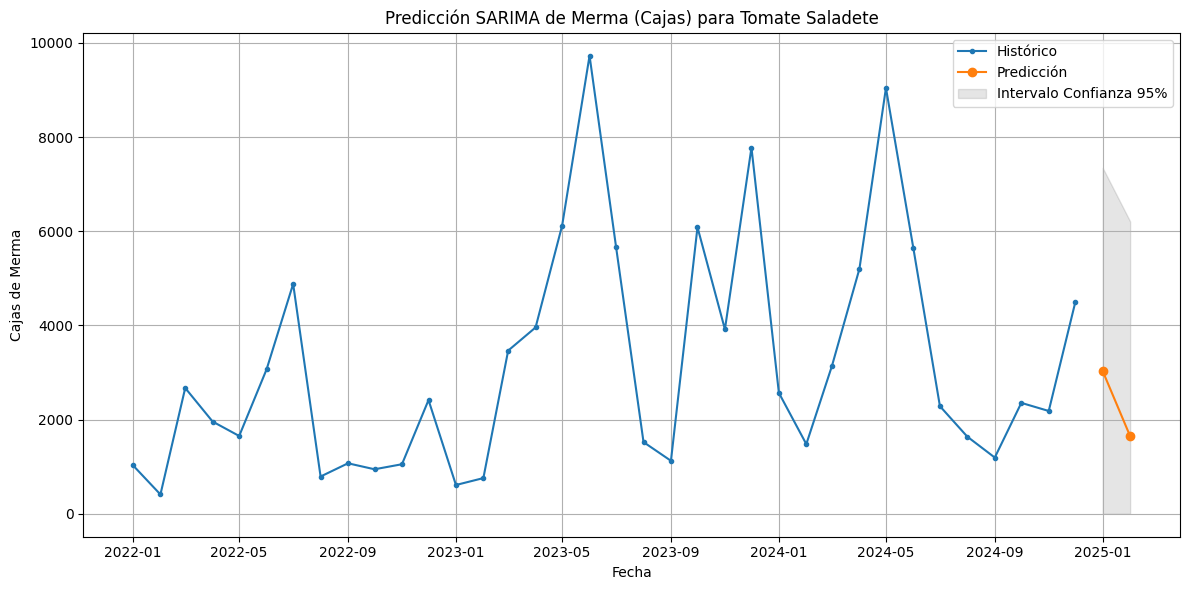


--- Entrenando modelo SARIMA para: Tomate Bola ---
Predicción SARIMA para Tomate Bola (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 2329.29 | 0            | 7734.72      |
| 2025-02-01 00:00:00 | 4104.82 | 0            | 11790.4      |


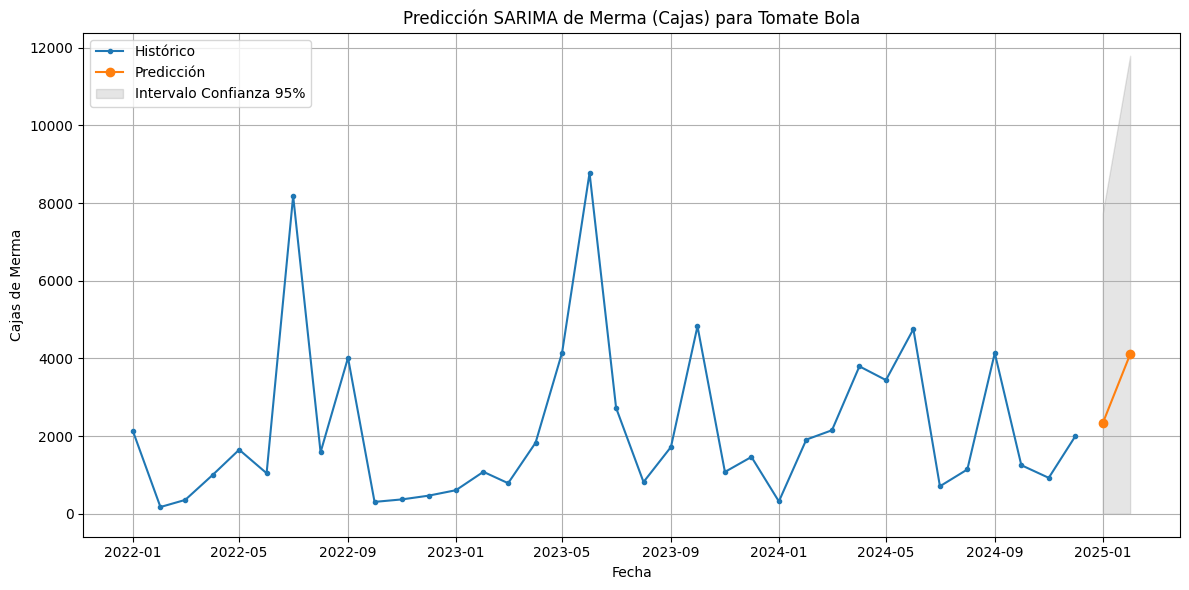


--- Entrenando modelo SARIMA para: Pepino ---
Predicción SARIMA para Pepino (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 101.154 | 0            | 226.196      |
| 2025-02-01 00:00:00 | 0       | 0            | 68.971       |


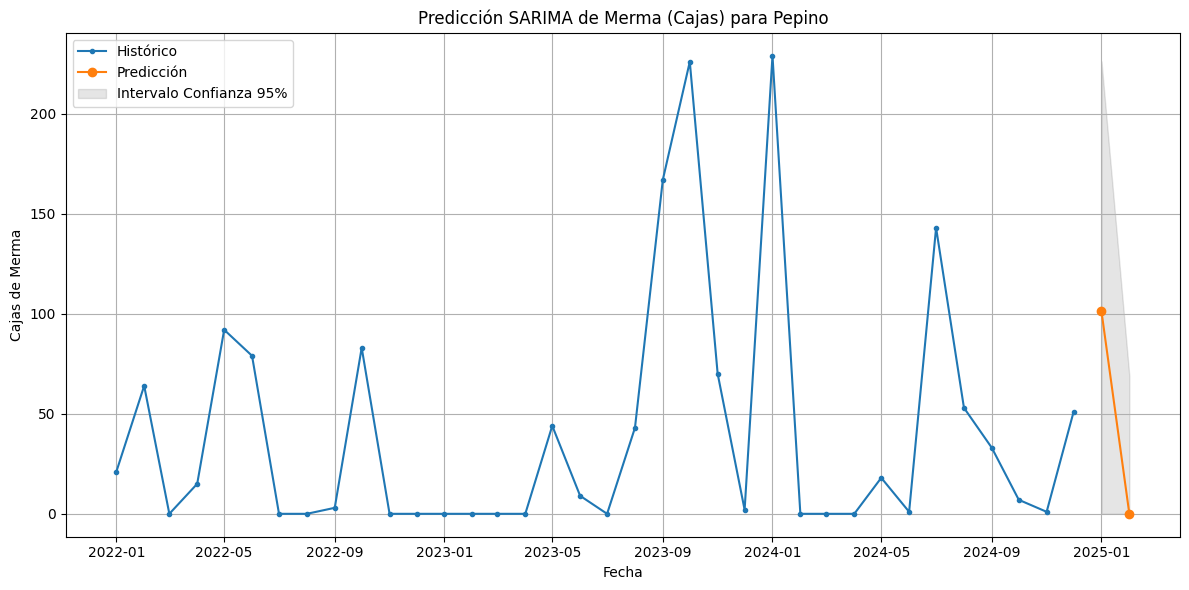


--- Entrenando modelo SARIMA para: Morron  ---
Predicción SARIMA para Morron  (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 52.2306 | 9.32432      | 95.1369      |
| 2025-02-01 00:00:00 | 36.9058 | 0            | 99.6321      |


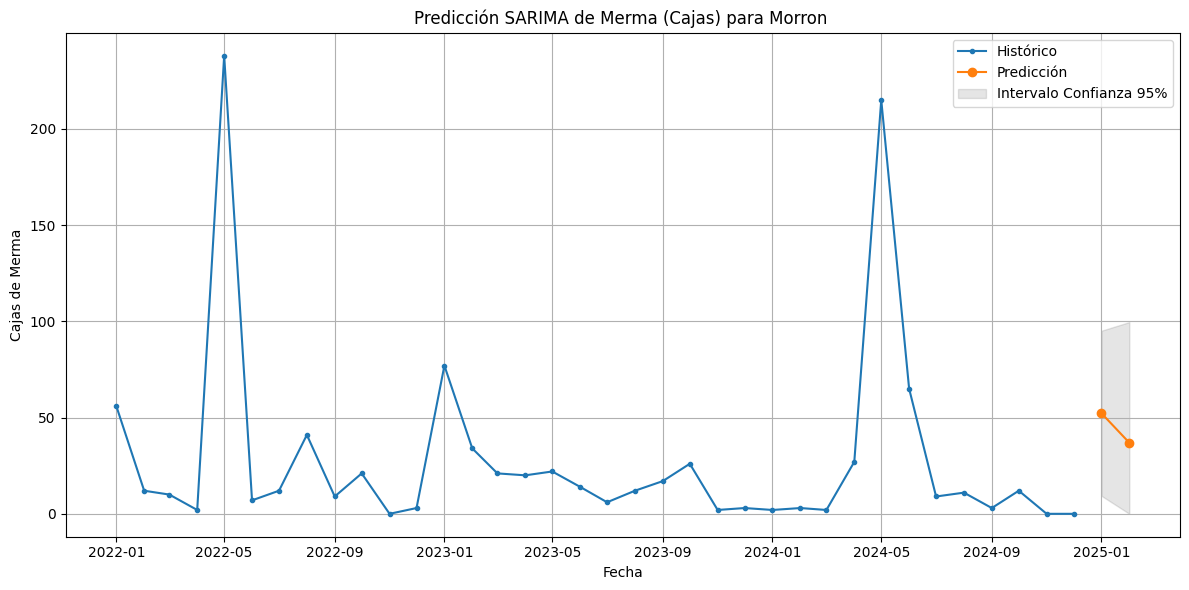


--- Entrenando modelo SARIMA para: Cebolla  ---
Predicción SARIMA para Cebolla  (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 6.65229 | 0            | 22.5171      |
| 2025-02-01 00:00:00 | 0       | 0            | 13.4557      |


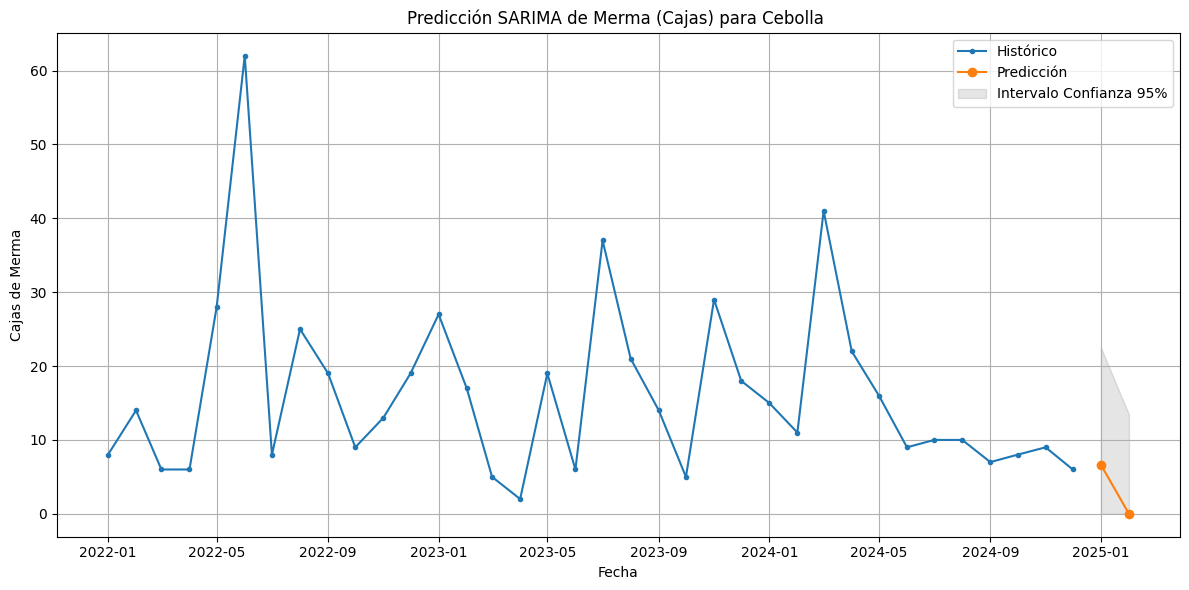


--- Entrenando modelo SARIMA para: Tomate Cherry ---
Predicción SARIMA para Tomate Cherry (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 0       | 0            | 41.3565      |
| 2025-02-01 00:00:00 | 114.545 | 58.7461      | 170.344      |


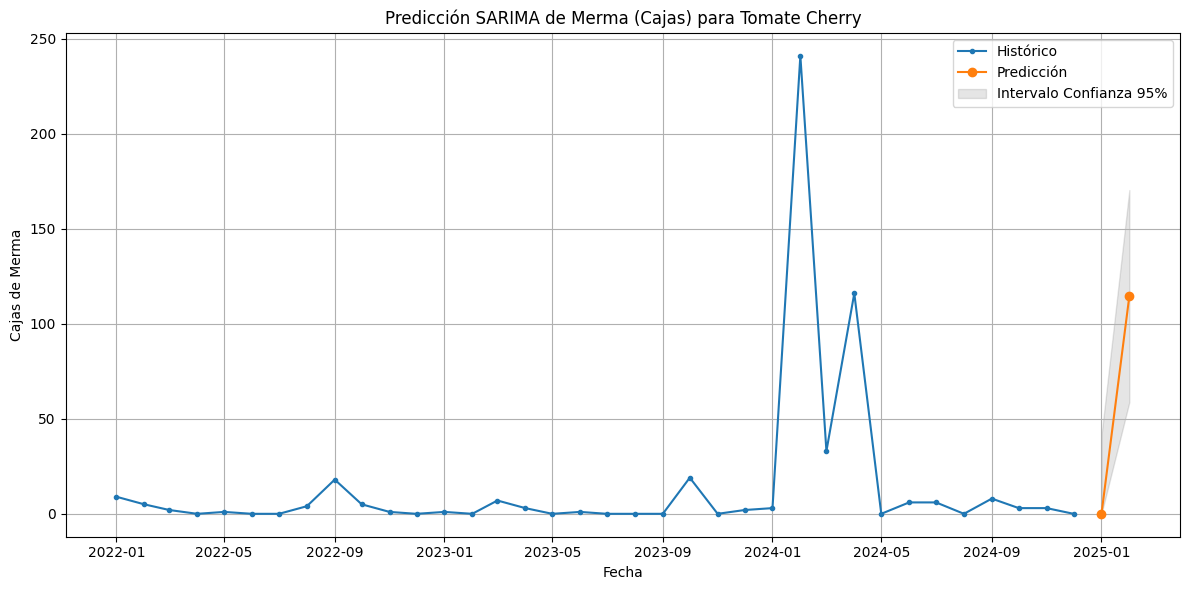


--- Entrenando modelo SARIMA para: Jalapeño ---
Predicción SARIMA para Jalapeño (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 29.3284 | 0            | 78.0245      |
| 2025-02-01 00:00:00 | 18.1625 | 0            | 68.7767      |


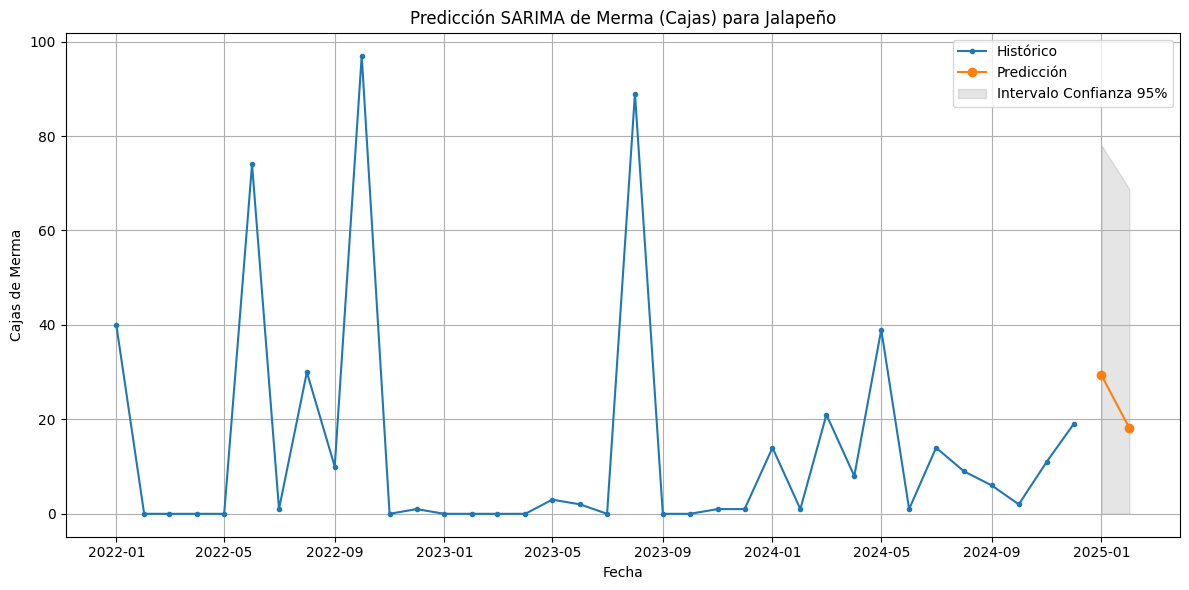


--- Entrenando modelo SARIMA para: Tomatillo ---
Predicción SARIMA para Tomatillo (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 39.4158 | 0            | 120.136      |
| 2025-02-01 00:00:00 | 40.2471 | 0            | 120.91       |


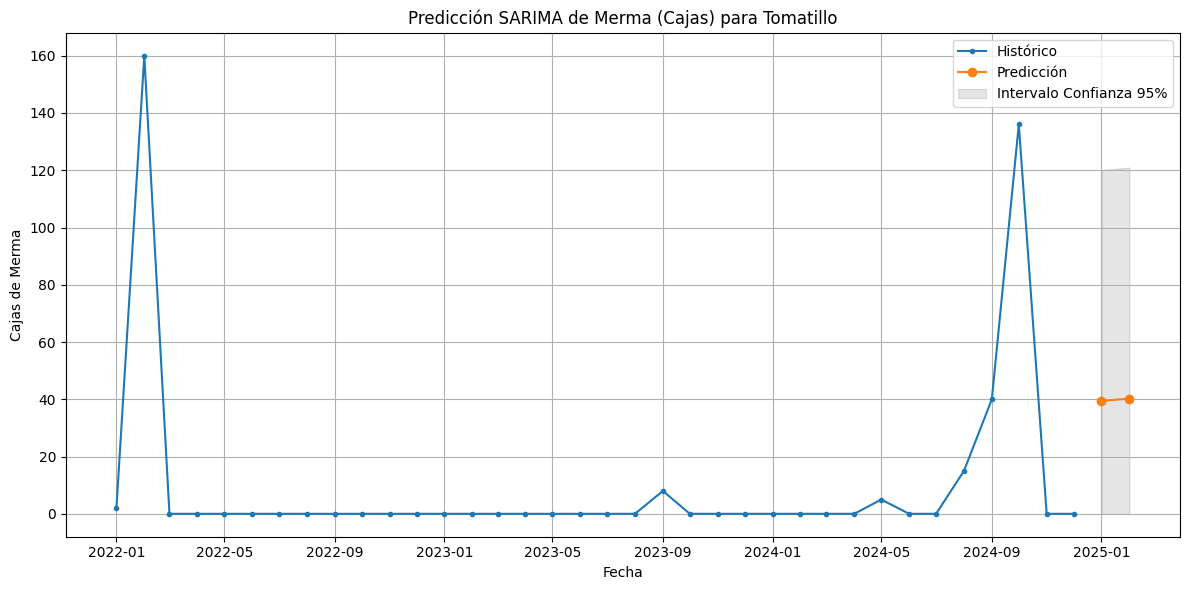


--- Entrenando modelo SARIMA para: Morron Rojo ---
Predicción SARIMA para Morron Rojo (próximos 2 meses):
| ds                  | yhat     | yhat_lower   | yhat_upper   |
|:--------------------|:---------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 4.15591  | 0            | 63.3191      |
| 2025-02-01 00:00:00 | 0.067819 | 0            | 58.6053      |


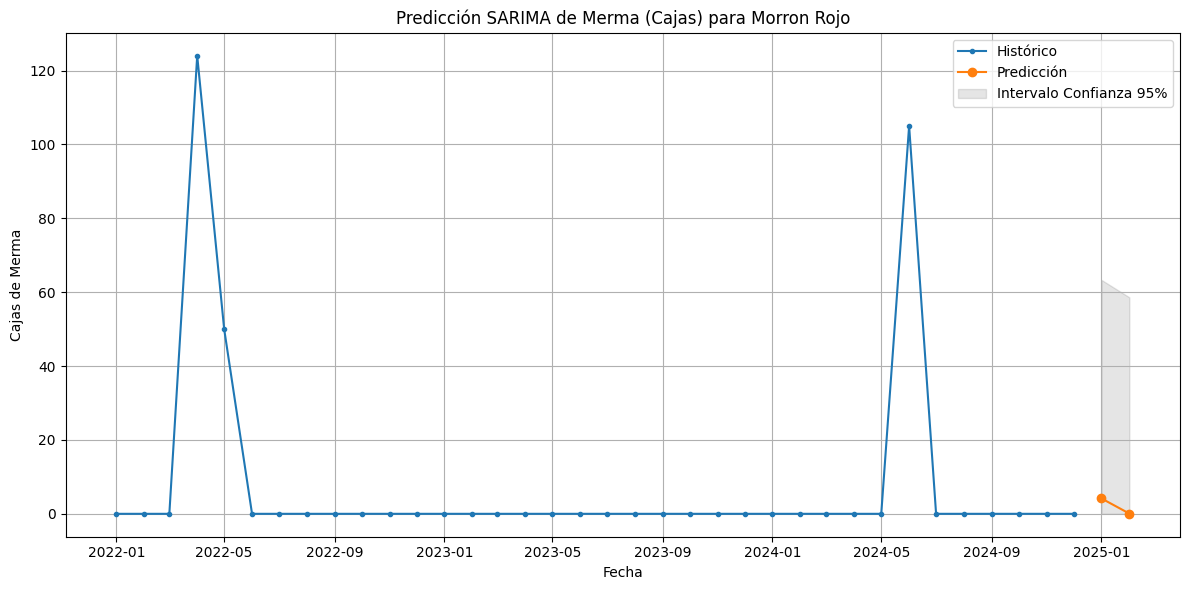


--- Entrenando modelo SARIMA para: Cebolla Morada ---
Predicción SARIMA para Cebolla Morada (próximos 2 meses):
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2025-01-01 00:00:00 | 10.4795 | 0            | 24.4103      |
| 2025-02-01 00:00:00 | 0       | 0            | 4.06712      |


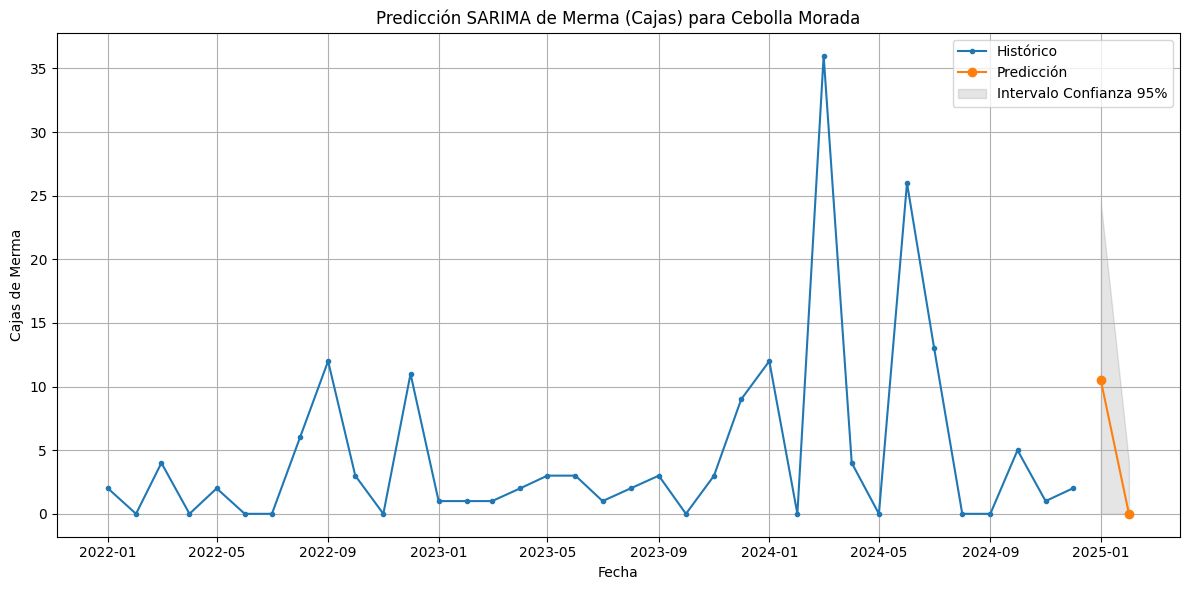


--- Resumen de Predicciones SARIMA (Próximos 3 Meses) ---
| Producto        | Fecha               | Prediccion_Cajas   | yhat_lower   | yhat_upper   |
|:----------------|:--------------------|:-------------------|:-------------|:-------------|
| Tomate Saladete | 2025-01-01 00:00:00 | 3030.63            | 0            | 7347.08      |
| Tomate Saladete | 2025-02-01 00:00:00 | 1649.01            | 0            | 6209.99      |
| Tomate Bola     | 2025-01-01 00:00:00 | 2329.29            | 0            | 7734.72      |
| Tomate Bola     | 2025-02-01 00:00:00 | 4104.82            | 0            | 11790.4      |
| Pepino          | 2025-01-01 00:00:00 | 101.154            | 0            | 226.196      |
| Pepino          | 2025-02-01 00:00:00 | 0                  | 0            | 68.971       |
| Morron          | 2025-01-01 00:00:00 | 52.2306            | 9.32432      | 95.1369      |
| Morron          | 2025-02-01 00:00:00 | 36.9058            | 0            | 99.6321      |
| Cebolla  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ignorar advertencias comunes de statsmodels esto se lo pedí a chatgpt porque salian muchos errores
import warnings
warnings.filterwarnings("ignore")


file_name = "/content/merma_bod_combinado_2022-2024.csv"


df = pd.read_csv(file_name)

month_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df['Month_Num'] = df['Month'].map(month_map)

# generar columna de fecha (usando el primer día del mes)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int) # imputar NaNs como 0 y convertir a int
df = df[df['Month_Num'] != 0] # borra filas donde el mes no se pudo mapear
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- Promedio historíco de temperaturas ---
# promedios históricos de temperatura media mensual en Fahrenheit (de timeanddate.com)
# ya que no tenemos nada más que la merma, de lo que nos podemos ayudar es de algún factor externo como la humedad relativa, mm de precipitación, o temperatura, yo ahorita agarré temperatura para ver si tiene alguna correlación entre merma y temperatura (pensando que a mayor temperatura las frutas duran menos, pero el pensamiento se puede extrapolar con otras condiciones incluso microeconómicas como el precio del producto o de la gasolina, etc.)
temp_f = {
    1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85,
    7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61
}
# Convertir a Celsius: C = (F - 32) * 5/9 gracias al buen chatgpt
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}

temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])


# agregarndo por fecha y producto
df_product_monthly = df.groupby(['Date', 'Producto'])['Cajas'].sum().reset_index()

# calculando merma total por producto para identificar los más importantes
total_spoilage_per_product = df_product_monthly.groupby('Producto')['Cajas'].sum().sort_values(ascending=False)

top_n = 10

print(f"Merma Total (Cajas) por Producto (Top {top_n}):")
print(total_spoilage_per_product.head(top_n).to_markdown(numalign="left", stralign="left"))

# tomamos los N productos principales para modelar (ej. Top 10 (todos))

top_products = total_spoilage_per_product.head(top_n).index.tolist()
print(f"\nSe modelarán los siguientes {top_n} productos principales: {', '.join(top_products)}")

all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, top_products], names=['Date', 'Producto'])

# reindexar y llenar con 0 los Cajas faltantes
df_model_data = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()

# añadir la columna de temperatura promedio histórica
df_model_data['Month_Num'] = df_model_data['Date'].dt.month
df_model_data = pd.merge(df_model_data, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# renombrar columnas clave ('Date' -> 'ds', 'Cajas' -> 'y') para mejor claridad (lo vi en un blog, después se los paso)
df_model_data = df_model_data.rename(columns={'Date': 'ds', 'Cajas': 'y'})

n_forecast_periods = 2 # dos meses (porque pos todo está en meses, pero podemos poner a 6 o 12, los que sean, la idea es que esto se corra diario o casi diario para que se pueda ir actualizando esta predicción)
last_date = df_model_data['ds'].max()
future_dates_sarima = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast_periods, freq='MS')

# el problema es que también se tiene que hacerse para las temperaturas futuras 🤷‍♂️
future_temp_df = pd.DataFrame({'ds': future_dates_sarima})
future_temp_df['Month_Num'] = future_temp_df['ds'].dt.month
# usando el mismo nombre de columna 'temp' que en los datos históricos
future_temp_df = pd.merge(future_temp_df, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# selecc solo la columna 'temp' como DataFrame y asegurar que no haya NaNs
future_exog = future_temp_df[['temp']] # Extraer como DataFrame
# rellenar NaNs si los hubiera (poco probable aquí, no vi la neta) con la media global histórica
if future_exog.isnull().values.any():
    mean_hist_temp = df_model_data['temp'].mean() # Calcular media de la columna 'temp' histórica
    print(f"Advertencia: Rellenando NaNs en temperaturas futuras con la media histórica ({mean_hist_temp:.1f}°C).")
    future_exog = future_exog.fillna(mean_hist_temp)

# SARIMA
forecasts_sarima = {}
models_sarima = {}

# entrenar el modelo y predecir para cada producto principal (que decidimos arriba ej 10)
for product in top_products:
    print(f"\n--- Entrenando modelo SARIMA para: {product} ---")
    # Filtrar datos para el producto actual
    product_data_sarima = df_model_data[df_model_data['Producto'] == product][['ds', 'y', 'temp']].copy()
    product_data_sarima = product_data_sarima.set_index('ds').sort_index()

    # separar variable endógena (y) y exógena (temp)
    endog = product_data_sarima['y']
    # asegurarse que exog sea un df con la columna 'temp'
    exog = product_data_sarima[['temp']] #por eso las dos brackets

    #rellenar NaNs en exog histórico si existen (poco probable)
    if exog.isnull().values.any():
         mean_prod_temp = exog['temp'].mean()
         print(f"Advertencia: Rellenando NaNs en la temperatura histórica para {product} con su media ({mean_prod_temp:.1f}°C).")
         exog = exog.fillna(mean_prod_temp)

    #verificar si hay suficientes datos
    if len(endog) < 24: # SARIMA a menudo necesita al menos 2 ciclos estacionales segun dicen
        print(f"Datos insuficientes (<24 meses) para modelar {product} con SARIMA. Saltando...")
        continue

    # Definir órdenes SARIMA (ejemplo: (0,1,1)x(0,1,1,12))
    # Esto es una heurística común, la optimización requeriría más análisis (ACF/PACF, grid search)
    order = (1, 1, 1) # (p, d, q)
    seasonal_order = (1, 1, 1, 12) # (P, D, Q, s=12 meses)

    try:
        # instanciar y entrenar el modelo SARIMAX
        model = SARIMAX(endog=endog,
                        exog=exog, # Pasar DataFrame histórico
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        trend='c') # 'c' = constante/intercepto

        results = model.fit(disp=False) # disp=False para menos output
        models_sarima[product] = results

        #realizar la predicción para los próximos 2 meses (esto lo pusimos en n_forecast_periods)
        # pasar el DataFrame future_exog que contiene la columna 'temp'
        forecast_obj = results.get_forecast(steps=n_forecast_periods, exog=future_exog.head(n_forecast_periods))
        forecast_values = forecast_obj.predicted_mean
        forecast_ci = forecast_obj.conf_int(alpha=0.05) # Intervalo de confianza del 95%

        # guardar predicción
        forecast_df = pd.DataFrame({
            'ds': future_dates_sarima,
            'yhat': forecast_values.values,
            'yhat_lower': forecast_ci.iloc[:, 0].values,
            'yhat_upper': forecast_ci.iloc[:, 1].values
        })
        #Asegurar que la merma no sea negativa
        forecast_df[['yhat', 'yhat_lower', 'yhat_upper']] = forecast_df[['yhat', 'yhat_lower', 'yhat_upper']].clip(lower=0)

        forecasts_sarima[product] = forecast_df

        print(f"Predicción SARIMA para {product} (próximos {n_forecast_periods} meses):")
        print(forecast_df.to_markdown(index=False, numalign="left", stralign="left"))

        #graficas
        plt.figure(figsize=(12, 6))
        plt.plot(endog.index, endog, label='Histórico', marker='.')
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Predicción', marker='o')
        plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'],
                         color='k', alpha=0.1, label='Intervalo Confianza 95%')
        plt.title(f'Predicción SARIMA de Merma (Cajas) para {product}')
        plt.xlabel('Fecha')
        plt.ylabel('Cajas de Merma')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al entrenar el modelo SARIMA para {product}: {e}")

#resumen
all_forecasts_list = []
for product, forecast_df in forecasts_sarima.items():
    forecast_df['Producto'] = product
    all_forecasts_list.append(forecast_df)

if all_forecasts_list:
    final_forecast_summary = pd.concat(all_forecasts_list)
    print("\n--- Resumen de Predicciones SARIMA (Próximos 3 Meses) ---")
    print(final_forecast_summary[['Producto', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Fecha', 'yhat': 'Prediccion_Cajas'}).to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("\nNo se pudieron generar predicciones SARIMA para los productos seleccionados.")

# analizar significancia del regresor de temperatura ---

print("\n--- Resumen Estadístico de los Modelos SARIMA ---")
print("Busca la fila 'temp' y verifica su coeficiente ('coef') y P-valor ('P>|z|').")
print("Un P-valor < 0.05 sugiere que la temperatura es un predictor significativo para ese producto.\n")

if not models_sarima:
    print("No se encontraron modelos SARIMA entrenados en la memoria.")
    print("Por favor, asegúrate de haber ejecutado el script de entrenamiento primero.")
else:
    for product, results in models_sarima.items():
        print(f"\n--- Resumen para: {product} ---")
        try:
            # Imprimir el resumen completo del modelo
            print(results.summary())
        except Exception as e:
            print(f"No se pudo obtener el resumen para {product}: {e}")

print("\n--- Fin del Análisis de Significancia ---")









In [ ]:
# -*- coding: utf-8 -*-
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools # Para generar combinaciones de órdenes
import time # Para medir el tiempo (opcional)

# Imports para ACF/PACF y SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller # Para prueba de estacionariedad (no usada para determinar d/D aquí)

# Ignorar advertencias comunes (opcional)
import warnings
warnings.filterwarnings("ignore")

# --- 1. Cargar y Preprocesar Datos (Reutilizado) ---

# Especificar el nombre del archivo
file_name = "merma_bod_combinado_2022-2024.csv"
df = pd.read_csv(file_name)

# Mapeo de meses
month_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df['Month_Num'] = df['Month'].map(month_map)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int)
df = df[df['Month_Num'] != 0]
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- 2. Definir Datos de Temperatura (Reutilizado) ---
temp_f = {
    1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85,
    7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61
}
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}
temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])

# --- 3. Preparar Datos para Modelado (Reutilizado) ---
df_product_monthly = df.groupby(['Date', 'Producto'])['Kilos'].sum().reset_index()
total_spoilage_per_product = df_product_monthly.groupby('Producto')['Kilos'].sum().sort_values(ascending=False)

# Usar los 10 productos principales
top_n = 10
top_products = total_spoilage_per_product.head(top_n).index.tolist()
print(f"Analizando los siguientes {top_n} productos principales: {', '.join(top_products)}")

# Asegurar rango completo de fechas y reindexar
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, top_products], names=['Date', 'Producto'])
df_model_data = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()

# Añadir temperatura y renombrar
df_model_data['Month_Num'] = df_model_data['Date'].dt.month
df_model_data = pd.merge(df_model_data, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')
df_model_data = df_model_data.rename(columns={'Date': 'ds', 'Kilos': 'y'})

# --- 4. Análisis ACF/PACF (Visual) ---
# (Se mantiene igual que el código anterior - genera gráficas ACF/PACF)
print("\n--- Generando Gráficas ACF/PACF ---")
for product in top_products:
    print(f"  - Para: {product}")
    # (Código de ploteo ACF/PACF aquí - omitido por brevedad, es igual al anterior)
    # ... (pegar el código de la sección 4 de la respuesta anterior aquí si se desea ejecutar) ...
    pass # Placeholder si omites el código de ploteo aquí

# --- 5. Búsqueda Manual de Hiperparámetros (Grid Search) ---
print("\n--- Ejecutando Búsqueda Manual de Órdenes SARIMA (Grid Search) ---")
print("ADVERTENCIA: Este proceso puede ser LENTO.")

# Definir rangos de órdenes a probar (¡Mantenlos pequeños para prueba!)
p_range = range(0, 2) # p = 0, 1
q_range = range(0, 2) # q = 0, 1
P_range = range(0, 2) # P = 0, 1
Q_range = range(0, 2) # Q = 0, 1
d = 1 # Orden de diferenciación no estacional FIJO (simplificación)
D = 1 # Orden de diferenciación estacional FIJO (simplificación)
s = 12 # Periodo estacional

# Generar todas las combinaciones de órdenes no estacionales y estacionales
order_combinations = list(itertools.product(p_range, q_range))
seasonal_order_combinations = list(itertools.product(P_range, Q_range))

best_models_manual = {}

for product in top_products:
    start_time_product = time.time()
    print(f"\n  - Buscando para: {product}")
    # Filtrar datos
    product_data = df_model_data[df_model_data['Producto'] == product].set_index('ds')
    endog = product_data['y']
    exog = product_data[['temp']] # Exógena como DataFrame

    # Verificar si hay suficientes datos
    # Necesitamos al menos s+1 obs para D=1, y más para órdenes p,q,P,Q > 0
    if len(endog) < s + 5:
        print(f"    * Datos insuficientes (< {s+5}) para ejecutar Grid Search en {product}.")
        continue

    # Rellenar NaNs en exog si existen
    if exog.isnull().values.any():
         mean_prod_temp = exog['temp'].mean()
         print(f"    * Advertencia: Rellenando NaNs en la temperatura para {product} con su media ({mean_prod_temp:.1f}°C).")
         exog = exog.fillna(mean_prod_temp)

    # Inicializar variables para guardar el mejor modelo para este producto
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    model_count = 0

    # Iterar sobre todas las combinaciones
    for order in order_combinations:
        current_p, current_q = order
        for seasonal_order_part in seasonal_order_combinations:
            current_P, current_Q = seasonal_order_part
            current_seasonal_order = (current_P, D, current_Q, s)
            current_full_order = (current_p, d, current_q)

            model_count += 1
            if model_count % 10 == 0: # Imprimir progreso cada 10 modelos
                 print(f"    ... probando modelo #{model_count}")

            try:
                # Ajustar el modelo SARIMAX
                model = SARIMAX(endog=endog,
                                exog=exog,
                                order=current_full_order,
                                seasonal_order=current_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend='c') # Puedes probar otros trends como 'n', 'ct'

                results = model.fit(disp=False) # disp=False para menos output

                # Guardar si el AIC es mejor
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = current_full_order
                    best_seasonal_order = current_seasonal_order

            except Exception as e:
                # Ignorar combinaciones que causen errores (ej. no convergencia)
                # print(f"      Error con orden {current_full_order}x{current_seasonal_order}: {e}")
                continue

    end_time_product = time.time()
    if best_order:
        print(f"    * Mejor Orden Manual encontrado para {product}: {best_order} x {best_seasonal_order}")
        print(f"    * AIC: {best_aic:.2f}")
        print(f"    * Tiempo de búsqueda: {end_time_product - start_time_product:.2f} segundos")
        best_models_manual[product] = {'order': best_order, 'seasonal_order': best_seasonal_order, 'aic': best_aic}
    else:
        print(f"    * No se encontró un modelo válido para {product} en los rangos probados.")


print("\n--- Resumen de Mejores Órdenes (Grid Search Manual) ---")
if best_models_manual:
    for product, params in best_models_manual.items():
        print(f"  - {product}: Orden={params['order']}, Orden Estacional={params['seasonal_order']}, AIC={params['aic']:.2f}")
else:
    print("No se encontraron mejores órdenes mediante Grid Search manual.")

print("\n--- Fin del Script de Análisis y Búsqueda Manual ---")

Analizando los siguientes 10 productos principales: Tomatillo, Jalapeño, Cebolla , Serrano, Cebolla Morada, Jalapeño Rojo, Cebolla amarilla, jalapeño chocolate , Ajo kgs, Poblano

--- Generando Gráficas ACF/PACF ---
  - Para: Tomatillo
  - Para: Jalapeño
  - Para: Cebolla 
  - Para: Serrano
  - Para: Cebolla Morada
  - Para: Jalapeño Rojo
  - Para: Cebolla amarilla
  - Para: jalapeño chocolate 
  - Para: Ajo kgs
  - Para: Poblano

--- Ejecutando Búsqueda Manual de Órdenes SARIMA (Grid Search) ---
ADVERTENCIA: Este proceso puede ser LENTO.

  - Buscando para: Tomatillo
    ... probando modelo #10
    * Mejor Orden Manual encontrado para Tomatillo: (0, 1, 1) x (0, 1, 1, 12)
    * AIC: 156.19
    * Tiempo de búsqueda: 5.56 segundos

  - Buscando para: Jalapeño
    ... probando modelo #10
    * Mejor Orden Manual encontrado para Jalapeño: (0, 1, 1) x (0, 1, 1, 12)
    * AIC: 151.79
    * Tiempo de búsqueda: 3.86 segundos

  - Buscando para: Cebolla 
    ... probando modelo #10
    * Mejor 

--- Iniciando Ingeniería de Características ---
--- Ingeniería de Características Completa (0.17 seg) ---
Forma final del DataFrame: (552, 21)
--- Entrenando Modelo XGBoost ---
--- Entrenamiento Completo (11.30 seg) ---
--- Preparando Datos Futuros ---
--- Realizando Predicciones Futuras ---

--- Predicciones de Merma con XGBoost (Próximos 3 Meses) ---
| Fecha               | Producto        | Prediccion_Kilos   |
|:--------------------|:----------------|:-------------------|
| 2025-01-01 00:00:00 | Cebolla         | 21.6127            |
| 2025-02-01 00:00:00 | Cebolla         | 19.3828            |
| 2025-03-01 00:00:00 | Cebolla         | 18.0848            |
| 2025-01-01 00:00:00 | Cebolla Morada  | 42.6054            |
| 2025-02-01 00:00:00 | Cebolla Morada  | 7.27812            |
| 2025-03-01 00:00:00 | Cebolla Morada  | 3.23248            |
| 2025-01-01 00:00:00 | Jalapeño        | 32.3994            |
| 2025-02-01 00:00:00 | Jalapeño        | 11.6029            |
| 2025-03-01 00

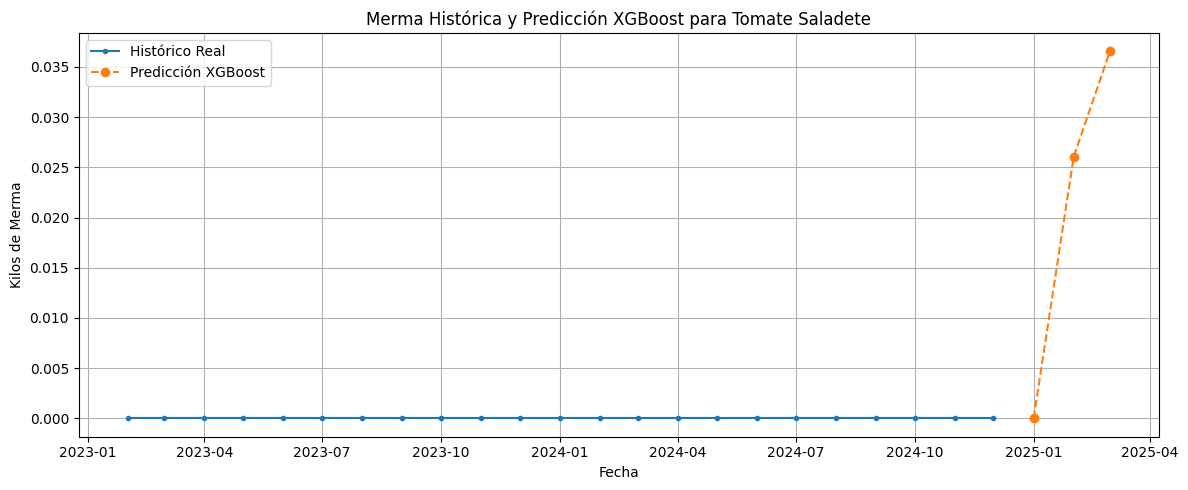

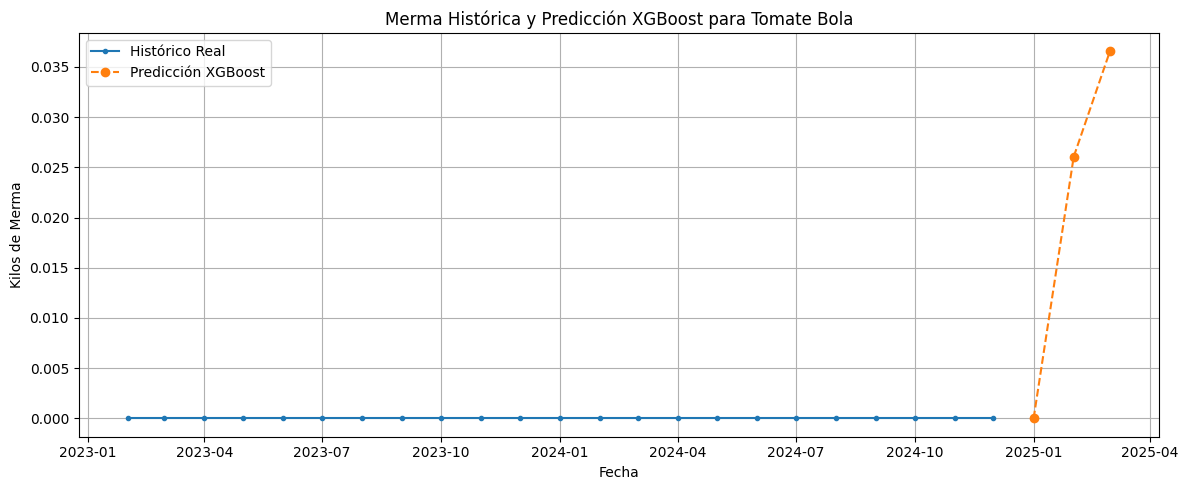

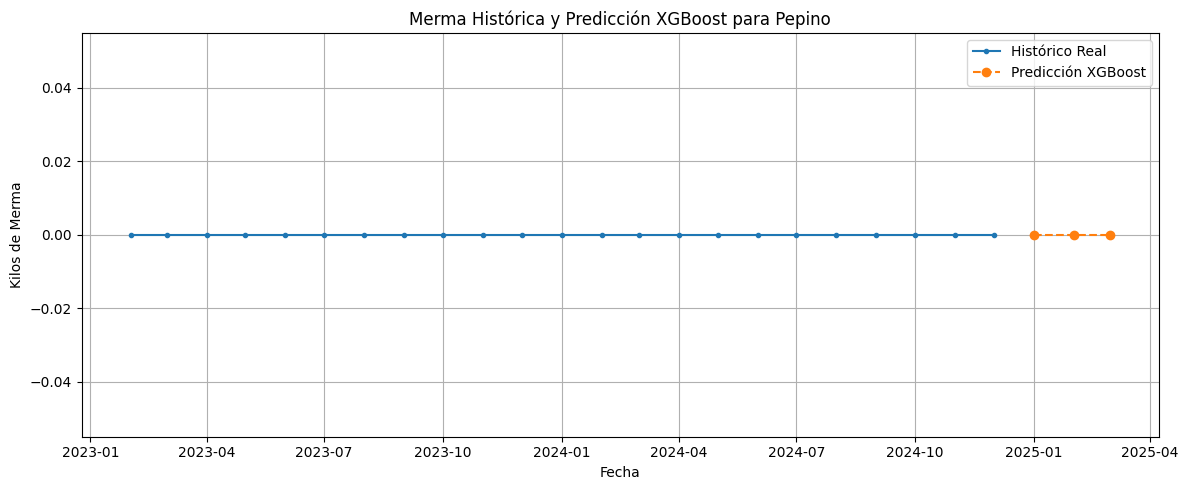


--- Fin del Script XGBoost ---


In [ ]:
# -*- coding: utf-8 -*-
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import time

# Ignorar advertencias comunes (opcional)
import warnings
warnings.filterwarnings("ignore")

# --- 1. Cargar y Preprocesar Datos ---

# Especificar el nombre del archivo
file_name = "merma_bod_combinado_2022-2024.csv"
df = pd.read_csv(file_name)

# Mapeo de meses
month_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df['Month_Num'] = df['Month'].map(month_map)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int)
df = df[df['Month_Num'] != 0]
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- 2. Definir Datos de Temperatura ---
temp_f = {
    1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85,
    7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61
}
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}
temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])

# --- 3. Preparar Datos Base para Modelado ---
df_product_monthly = df.groupby(['Date', 'Producto'])['Kilos'].sum().reset_index()

# Usar todos los productos o filtrar por los top N si se desea
# Aquí usamos todos los productos que aparecen en el histórico
all_products = df_product_monthly['Producto'].unique()
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, all_products], names=['Date', 'Producto'])

df_model_base = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()

# Añadir temperatura y renombrar
df_model_base['Month_Num'] = df_model_base['Date'].dt.month
df_model_base = pd.merge(df_model_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')
df_model_base = df_model_base.rename(columns={'Date': 'ds', 'Kilos': 'y'})
df_model_base = df_model_base.sort_values(by=['Producto', 'ds'])


# --- 4. Ingeniería de Características (Feature Engineering) ---
print("--- Iniciando Ingeniería de Características ---")
start_fe = time.time()

# a) Características de Fecha
df_model_base['month'] = df_model_base['ds'].dt.month
df_model_base['year'] = df_model_base['ds'].dt.year
df_model_base['quarter'] = df_model_base['ds'].dt.quarter
df_model_base['dayofyear'] = df_model_base['ds'].dt.dayofyear

# b) Características de Lag (retrasos)
# Calcular lags agrupando por producto para evitar que se mezclen series
lags = [1, 2, 3, 12, 13] # Mes anterior, hace 2, hace 3, hace 1 año, hace 1 año y 1 mes
for lag in lags:
    df_model_base[f'y_lag_{lag}'] = df_model_base.groupby('Producto')['y'].shift(lag)

# c) Características de Ventana Móvil (Rolling Window)
windows = [3, 6, 12] # Ventanas de 3, 6, 12 meses
for window in windows:
    # La ventana incluye el mes actual (shift(1) para que sea solo basado en el pasado)
    df_model_base[f'y_roll_mean_{window}'] = df_model_base.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).mean()
    df_model_base[f'y_roll_std_{window}'] = df_model_base.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).std()

# d) Codificación del Producto (Label Encoding)
# XGBoost puede manejar enteros como categorías si se le indica, pero LabelEncoder es simple
le = LabelEncoder()
df_model_base['producto_encoded'] = le.fit_transform(df_model_base['Producto'])
# Guardar el mapeo para referencia futura si es necesario
producto_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Eliminar filas con NaNs generados por lags/rolling
df_model_ready = df_model_base.dropna(subset=[col for col in df_model_base.columns if 'lag' in col or 'roll' in col])

end_fe = time.time()
print(f"--- Ingeniería de Características Completa ({end_fe - start_fe:.2f} seg) ---")
print(f"Forma final del DataFrame: {df_model_ready.shape}")
# print(df_model_ready.head().to_markdown(index=False)) # Descomentar para ver

# --- 5. Preparación para XGBoost (Definir Features y Target) ---
# Seleccionar características (excluir columnas no numéricas o de identificación innecesarias)
features = [
    'month', 'year', 'quarter', 'dayofyear', 'temp', 'producto_encoded',
] + [col for col in df_model_ready.columns if 'lag' in col or 'roll' in col]

target = 'y'

X = df_model_ready[features]
y = df_model_ready[target]

# --- 6. Entrenar Modelo XGBoost ---
# No hacemos split aquí, entrenamos con todos los datos históricos disponibles
# para hacer la predicción futura. Para evaluar el modelo, sí haríamos un split temporal.
print("--- Entrenando Modelo XGBoost ---")
start_train = time.time()

# Habilitar manejo de categorías directamente en XGBoost (opcional, requiere versión >= 1.3)
# X['producto_encoded'] = X['producto_encoded'].astype('category')

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Objetivo para regresión
    n_estimators=1000,            # Número de árboles (puede requerir ajuste)
    learning_rate=0.01,          # Tasa de aprendizaje (puede requerir ajuste)
    max_depth=7,                 # Profundidad máxima (puede requerir ajuste)
    subsample=0.8,               # Fracción de muestras por árbol
    colsample_bytree=0.8,        # Fracción de features por árbol
    random_state=42,
    n_jobs=-1                    # Usar todos los cores disponibles
    # enable_categorical=True   # Habilitar si se usa dtype 'category' para producto_encoded
    # early_stopping_rounds=50  # <---- ¡Eliminada o comentada!
)


# Para usar early stopping, necesitaríamos un set de evaluación (ej. los últimos meses)
# Por simplicidad para la predicción final, entrenamos sin él por ahora.
# Si se quisiera evaluar:
# last_date_train = df_model_ready['ds'].max() - pd.DateOffset(months=3)
# X_train, y_train = X[df_model_ready['ds'] <= last_date_train], y[df_model_ready['ds'] <= last_date_train]
# X_eval, y_eval = X[df_model_ready['ds'] > last_date_train], y[df_model_ready['ds'] > last_date_train]
# xgb_model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)

# Entrenando con todos los datos disponibles para la predicción final:
xgb_model.fit(X, y, verbose=False)

end_train = time.time()
print(f"--- Entrenamiento Completo ({end_train - start_train:.2f} seg) ---")


# --- 7. Preparar Datos Futuros para Predicción ---
print("--- Preparando Datos Futuros ---")
n_forecast_periods = 3
last_hist_date = df_model_base['ds'].max() # Última fecha en los datos base (antes de quitar NaNs)
future_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1), periods=n_forecast_periods, freq='MS')

# Crear DataFrame futuro base (para todos los productos)
future_df_list = []
for prod_encoded in df_model_base['producto_encoded'].unique():
    prod_name = le.inverse_transform([prod_encoded])[0] # Obtener nombre del producto
    temp_df_future = pd.DataFrame({'ds': future_dates, 'producto_encoded': prod_encoded, 'Producto': prod_name})
    future_df_list.append(temp_df_future)

future_data_base = pd.concat(future_df_list).sort_values(by=['producto_encoded', 'ds']).reset_index(drop=True)

# Añadir temperatura futura
future_data_base['Month_Num'] = future_data_base['ds'].dt.month
future_data_base = pd.merge(future_data_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# Crear características de fecha futuras
future_data_base['month'] = future_data_base['ds'].dt.month
future_data_base['year'] = future_data_base['ds'].dt.year
future_data_base['quarter'] = future_data_base['ds'].dt.quarter
future_data_base['dayofyear'] = future_data_base['ds'].dt.dayofyear

# Crear características de Lag y Rolling para el futuro (APROXIMACIÓN)
# Concatenar histórico y futuro temporalmente para calcular lags/rolling que cruzan la frontera
df_for_future_features = pd.concat([df_model_base, future_data_base], ignore_index=True).sort_values(by=['Producto', 'ds'])

for lag in lags:
    future_data_base[f'y_lag_{lag}'] = df_for_future_features.groupby('Producto')['y'].shift(lag).loc[future_data_base.index]

for window in windows:
    future_data_base[f'y_roll_mean_{window}'] = df_for_future_features.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).mean().loc[future_data_base.index]
    future_data_base[f'y_roll_std_{window}'] = df_for_future_features.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).std().loc[future_data_base.index]

# Manejar NaNs en las características futuras (ej. rellenar con 0 o media si es necesario)
# Especialmente el std dev puede ser NaN si hay pocos puntos en la ventana inicial
future_data_base = future_data_base.fillna(0) # Rellenar NaNs restantes con 0 (simplificación)

# Seleccionar las mismas características que para el entrenamiento
X_future = future_data_base[features]
# if 'producto_encoded' in X_future.columns: # Convertir a categoría si se usó en entrenamiento
#     X_future['producto_encoded'] = X_future['producto_encoded'].astype('category')


# --- 8. Predecir ---
print("--- Realizando Predicciones Futuras ---")
future_predictions = xgb_model.predict(X_future)

# Asegurar que las predicciones no sean negativas
future_predictions[future_predictions < 0] = 0

# Crear DataFrame de resultados
results_df = future_data_base[['ds', 'Producto']].copy()
results_df['Prediccion_Kilos'] = future_predictions

# --- 9. Mostrar Resultados ---
print("\n--- Predicciones de Merma con XGBoost (Próximos 3 Meses) ---")

# Filtrar por los Top N productos para visualización más limpia (opcional)
results_df_top_n = results_df[results_df['Producto'].isin(top_products)]
print(results_df_top_n.rename(columns={'ds': 'Fecha'}).to_markdown(index=False, numalign="left", stralign="left"))

# (Opcional) Graficar predicciones para algunos productos
print("\n--- Graficando Predicciones (Ejemplo para algunos productos) ---")
products_to_plot = top_products[:3] # Graficar los 3 primeros

for product in products_to_plot:
    plt.figure(figsize=(12, 5))

    # Histórico
    hist_data = df_model_ready[df_model_ready['Producto'] == product]
    plt.plot(hist_data['ds'], hist_data['y'], label='Histórico Real', marker='.', linestyle='-')

    # Predicción futura
    pred_data = results_df[results_df['Producto'] == product]
    plt.plot(pred_data['ds'], pred_data['Prediccion_Kilos'], label='Predicción XGBoost', marker='o', linestyle='--')

    plt.title(f'Merma Histórica y Predicción XGBoost para {product}')
    plt.xlabel('Fecha')
    plt.ylabel('Kilos de Merma')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


print("\n--- Fin del Script XGBoost ---")

--- Iniciando Ingeniería de Características para Cajas---
--- Ingeniería de Características Completa (0.02 seg) ---
Forma final del DataFrame: (552, 21)
--- Entrenando Modelo XGBoost para Cajas ---
--- Entrenamiento Completo (1.29 seg) ---
--- Preparando Datos Futuros para Cajas ---
--- Realizando Predicciones Futuras de Cajas ---

--- Predicciones de Merma (Cajas) con XGBoost (Próximos 3 Meses) ---
| Fecha               | Producto        | Prediccion_Cajas   |
|:--------------------|:----------------|:-------------------|
| 2025-01-01 00:00:00 | Cebolla         | 0.0612669          |
| 2025-02-01 00:00:00 | Cebolla         | 0.107325           |
| 2025-03-01 00:00:00 | Cebolla         | 0.188752           |
| 2025-01-01 00:00:00 | Cebolla Morada  | 0.0612669          |
| 2025-02-01 00:00:00 | Cebolla Morada  | 0.107325           |
| 2025-03-01 00:00:00 | Cebolla Morada  | 0.188752           |
| 2025-01-01 00:00:00 | Jalapeño        | 8.11858            |
| 2025-02-01 00:00:00 | Jalape

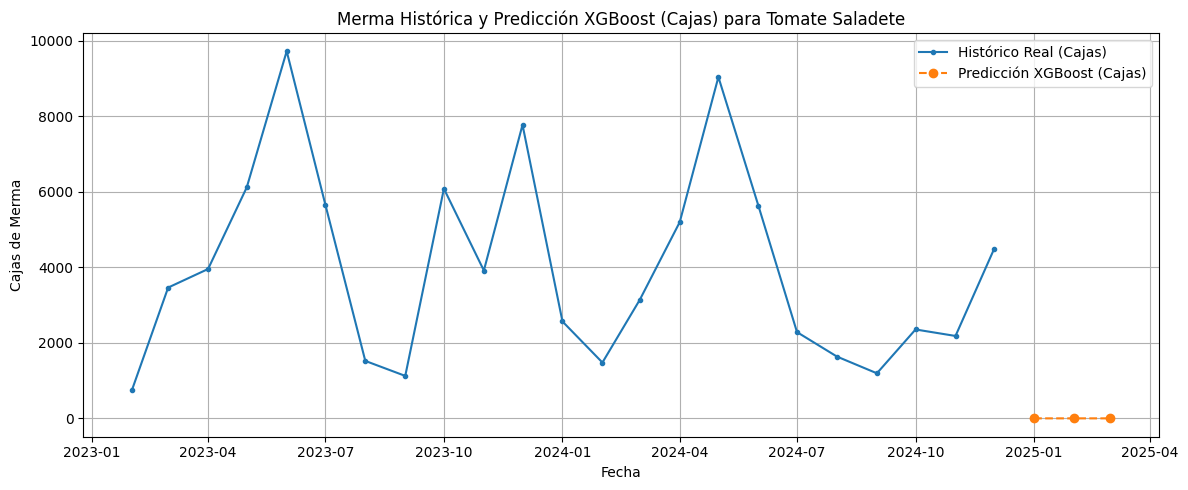

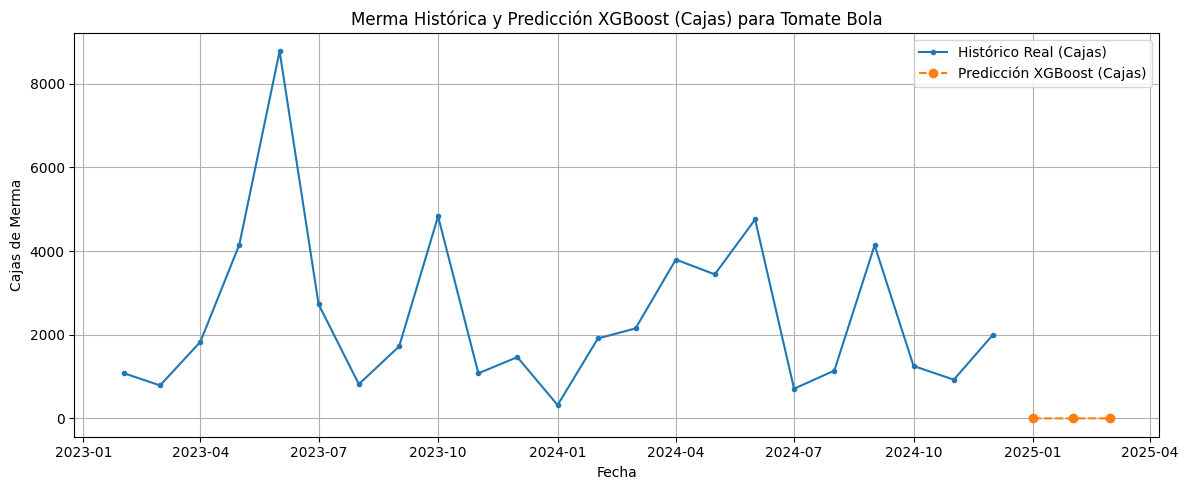

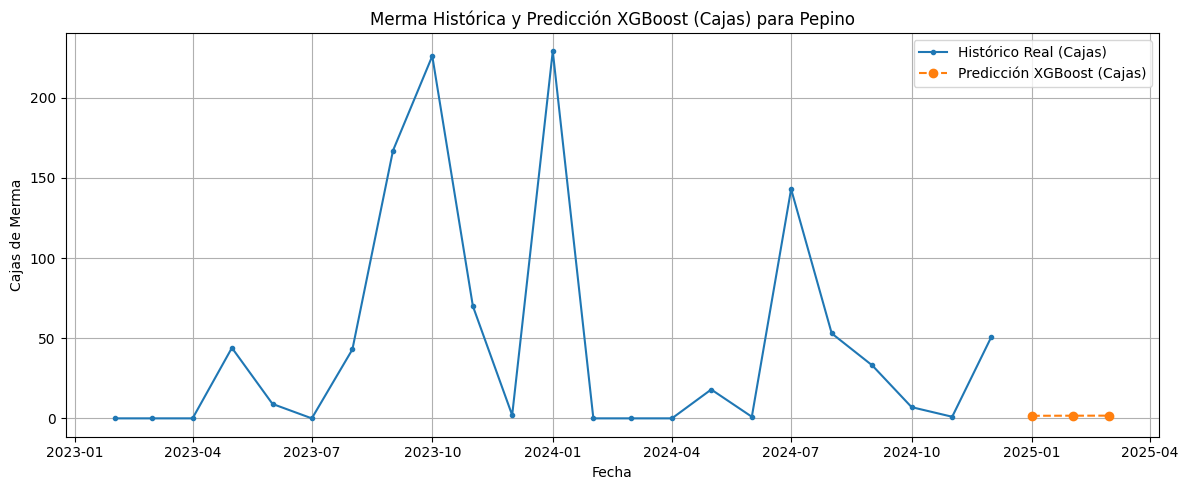


--- Fin del Script XGBoost para Cajas ---


In [ ]:
# -*- coding: utf-8 -*-
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import time

# Ignorar advertencias comunes (opcional)
import warnings
warnings.filterwarnings("ignore")

# --- 1. Cargar y Preprocesar Datos ---

# Especificar el nombre del archivo
file_name = "merma_bod_combinado_2022-2024.csv"
df = pd.read_csv(file_name)

# Mapeo de meses
month_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df['Month_Num'] = df['Month'].map(month_map)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int)
df = df[df['Month_Num'] != 0]
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- 2. Definir Datos de Temperatura ---
temp_f = {
    1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85,
    7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61
}
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}
temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])

# --- 3. Preparar Datos Base para Modelado (Agregando 'Cajas') ---
# CAMBIO: Agrupar y sumar 'Cajas' en lugar de 'Kilos'
df_product_monthly = df.groupby(['Date', 'Producto'])['Cajas'].sum().reset_index()

# Usar todos los productos o filtrar por los top N si se desea
all_products = df_product_monthly['Producto'].unique()
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, all_products], names=['Date', 'Producto'])

df_model_base = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()

# Añadir temperatura
df_model_base['Month_Num'] = df_model_base['Date'].dt.month
df_model_base = pd.merge(df_model_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# CAMBIO: Renombrar 'Cajas' a 'y' como variable objetivo
df_model_base = df_model_base.rename(columns={'Date': 'ds', 'Cajas': 'y'})
df_model_base = df_model_base.sort_values(by=['Producto', 'ds'])


# --- 4. Ingeniería de Características (Feature Engineering) ---
# (La lógica es la misma, pero ahora 'y' representa 'Cajas')
print("--- Iniciando Ingeniería de Características para Cajas---")
start_fe = time.time()

# a) Características de Fecha
df_model_base['month'] = df_model_base['ds'].dt.month
df_model_base['year'] = df_model_base['ds'].dt.year
df_model_base['quarter'] = df_model_base['ds'].dt.quarter
df_model_base['dayofyear'] = df_model_base['ds'].dt.dayofyear

# b) Características de Lag (retrasos de 'y', que ahora es 'Cajas')
lags = [1, 2, 3, 12, 13]
for lag in lags:
    df_model_base[f'y_lag_{lag}'] = df_model_base.groupby('Producto')['y'].shift(lag)

# c) Características de Ventana Móvil (Rolling Window de 'y', que ahora es 'Cajas')
windows = [3, 6, 12]
for window in windows:
    df_model_base[f'y_roll_mean_{window}'] = df_model_base.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).mean()
    df_model_base[f'y_roll_std_{window}'] = df_model_base.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).std()

# d) Codificación del Producto (Label Encoding)
le = LabelEncoder()
df_model_base['producto_encoded'] = le.fit_transform(df_model_base['Producto'])
producto_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Eliminar filas con NaNs generados por lags/rolling
df_model_ready = df_model_base.dropna(subset=[col for col in df_model_base.columns if 'lag' in col or 'roll' in col])

end_fe = time.time()
print(f"--- Ingeniería de Características Completa ({end_fe - start_fe:.2f} seg) ---")
print(f"Forma final del DataFrame: {df_model_ready.shape}")

# --- 5. Preparación para XGBoost (Definir Features y Target 'y' = Cajas) ---
features = [
    'month', 'year', 'quarter', 'dayofyear', 'temp', 'producto_encoded',
] + [col for col in df_model_ready.columns if 'lag' in col or 'roll' in col]

target = 'y' # 'y' ahora representa 'Cajas'

X = df_model_ready[features]
y = df_model_ready[target]

# --- 6. Entrenar Modelo XGBoost ---
print("--- Entrenando Modelo XGBoost para Cajas ---")
start_train = time.time()

xgb_model_cajas = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
    # Sin early_stopping_rounds para entrenar con todos los datos
)

# Entrenando con todos los datos disponibles para la predicción final:
xgb_model_cajas.fit(X, y, verbose=False)

end_train = time.time()
print(f"--- Entrenamiento Completo ({end_train - start_train:.2f} seg) ---")


# --- 7. Preparar Datos Futuros para Predicción ---
print("--- Preparando Datos Futuros para Cajas ---")
n_forecast_periods = 3
last_hist_date = df_model_base['ds'].max()
future_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1), periods=n_forecast_periods, freq='MS')

# Crear DataFrame futuro base
future_df_list = []
for prod_encoded in df_model_base['producto_encoded'].unique():
    prod_name = le.inverse_transform([prod_encoded])[0]
    temp_df_future = pd.DataFrame({'ds': future_dates, 'producto_encoded': prod_encoded, 'Producto': prod_name})
    future_df_list.append(temp_df_future)

future_data_base = pd.concat(future_df_list).sort_values(by=['producto_encoded', 'ds']).reset_index(drop=True)

# Añadir temperatura futura
future_data_base['Month_Num'] = future_data_base['ds'].dt.month
future_data_base = pd.merge(future_data_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')

# Crear características de fecha futuras
future_data_base['month'] = future_data_base['ds'].dt.month
future_data_base['year'] = future_data_base['ds'].dt.year
future_data_base['quarter'] = future_data_base['ds'].dt.quarter
future_data_base['dayofyear'] = future_data_base['ds'].dt.dayofyear

# Crear características de Lag y Rolling para el futuro (APROXIMACIÓN)
df_for_future_features = pd.concat([df_model_base, future_data_base], ignore_index=True).sort_values(by=['Producto', 'ds'])

# 'y' en df_for_future_features ahora es Cajas históricas y NaN para futuro
for lag in lags:
    future_data_base[f'y_lag_{lag}'] = df_for_future_features.groupby('Producto')['y'].shift(lag).loc[future_data_base.index]

for window in windows:
    future_data_base[f'y_roll_mean_{window}'] = df_for_future_features.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).mean().loc[future_data_base.index]
    future_data_base[f'y_roll_std_{window}'] = df_for_future_features.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).std().loc[future_data_base.index]

# Manejar NaNs en las características futuras
future_data_base = future_data_base.fillna(0)

# Seleccionar las mismas características que para el entrenamiento
X_future = future_data_base[features]

# --- 8. Predecir ---
print("--- Realizando Predicciones Futuras de Cajas ---")
future_predictions_cajas = xgb_model_cajas.predict(X_future)

# Asegurar que las predicciones no sean negativas (las cajas deben ser >= 0)
future_predictions_cajas[future_predictions_cajas < 0] = 0
# Opcional: Redondear a entero más cercano si las cajas deben ser enteras
# future_predictions_cajas = np.round(future_predictions_cajas)

# Crear DataFrame de resultados
results_df_cajas = future_data_base[['ds', 'Producto']].copy()
# CAMBIO: Nombre de columna de predicción
results_df_cajas['Prediccion_Cajas'] = future_predictions_cajas

# --- 9. Mostrar Resultados ---
print("\n--- Predicciones de Merma (Cajas) con XGBoost (Próximos 3 Meses) ---")

# Filtrar por los Top N productos para visualización (usando los top de Kilos como referencia)
# O recalcular top N basado en Cajas si se prefiere
top_products_kilos = total_spoilage_per_product.head(10).index.tolist() # Usamos los mismos top 10
results_df_top_n_cajas = results_df_cajas[results_df_cajas['Producto'].isin(top_products_kilos)]
# CAMBIO: Nombre de columna en la tabla de salida
print(results_df_top_n_cajas.rename(columns={'ds': 'Fecha'}).to_markdown(index=False, numalign="left", stralign="left"))

# (Opcional) Graficar predicciones
print("\n--- Graficando Predicciones de Cajas (Ejemplo para algunos productos) ---")
products_to_plot = top_products_kilos[:3] # Graficar los 3 primeros

for product in products_to_plot:
    plt.figure(figsize=(12, 5))

    # Histórico ('y' ahora es Cajas)
    hist_data = df_model_ready[df_model_ready['Producto'] == product]
    plt.plot(hist_data['ds'], hist_data['y'], label='Histórico Real (Cajas)', marker='.', linestyle='-')

    # Predicción futura
    pred_data = results_df_cajas[results_df_cajas['Producto'] == product]
    plt.plot(pred_data['ds'], pred_data['Prediccion_Cajas'], label='Predicción XGBoost (Cajas)', marker='o', linestyle='--')

    plt.title(f'Merma Histórica y Predicción XGBoost (Cajas) para {product}')
    plt.xlabel('Fecha')
    # CAMBIO: Etiqueta del eje Y
    plt.ylabel('Cajas de Merma')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


print("\n--- Fin del Script XGBoost para Cajas ---")

Preparando datos LSTM para los siguientes 5 productos: Tomate Saladete, Tomate Bola, Pepino, Morron , Cebolla 

--- Procesando Producto: Tomate Saladete ---
  * Datos preparados: X_seq shape=(22, 12, 2), y_seq shape=(22, 3)
  * División: 18 entrenamiento, 4 validación.
  * Entrenando modelo LSTM...
  * Entrenamiento completado.
  * Procesamiento completo para Tomate Saladete (17.83 seg)

--- Procesando Producto: Tomate Bola ---
  * Datos preparados: X_seq shape=(22, 12, 2), y_seq shape=(22, 3)
  * División: 18 entrenamiento, 4 validación.
  * Entrenando modelo LSTM...
  * Entrenamiento completado.
  * Procesamiento completo para Tomate Bola (9.29 seg)

--- Procesando Producto: Pepino ---
  * Datos preparados: X_seq shape=(22, 12, 2), y_seq shape=(22, 3)
  * División: 18 entrenamiento, 4 validación.
  * Entrenando modelo LSTM...
  * Entrenamiento completado.
  * Procesamiento completo para Pepino (5.75 seg)

--- Procesando Producto: Morron  ---
  * Datos preparados: X_seq shape=(22, 12,

  * Procesamiento completo para Cebolla  (5.20 seg)

--- Predicciones de Merma (Cajas) con LSTM (Próximos 3 Meses) ---
| Fecha               | Producto        | Prediccion_Cajas   |
|:--------------------|:----------------|:-------------------|
| 2025-01-01 00:00:00 | Tomate Saladete | 2096.91            |
| 2025-02-01 00:00:00 | Tomate Saladete | 2887.56            |
| 2025-03-01 00:00:00 | Tomate Saladete | 2449.28            |
| 2025-01-01 00:00:00 | Tomate Bola     | 1882.57            |
| 2025-02-01 00:00:00 | Tomate Bola     | 2036.87            |
| 2025-03-01 00:00:00 | Tomate Bola     | 2177.4             |
| 2025-01-01 00:00:00 | Pepino          | 23.3036            |
| 2025-02-01 00:00:00 | Pepino          | 18.7029            |
| 2025-03-01 00:00:00 | Pepino          | 21.5045            |
| 2025-01-01 00:00:00 | Morron          | 16.0847            |
| 2025-02-01 00:00:00 | Morron          | 23.1784            |
| 2025-03-01 00:00:00 | Morron          | 25.2107            |

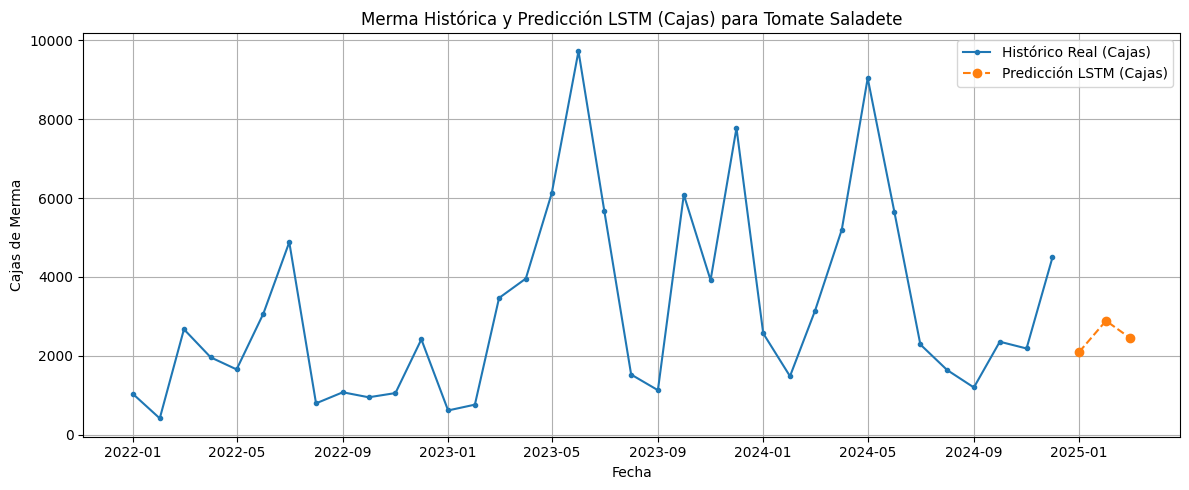

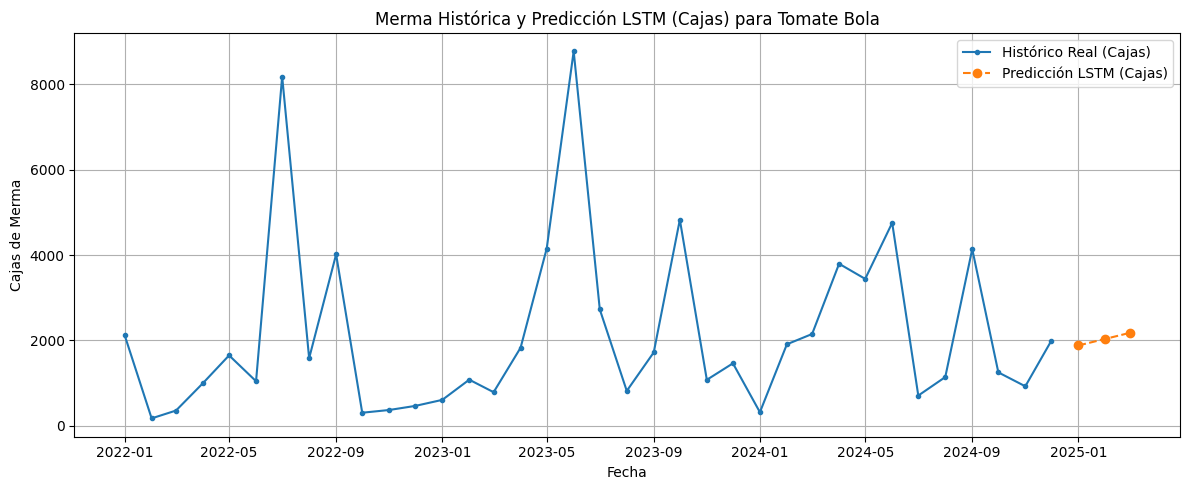

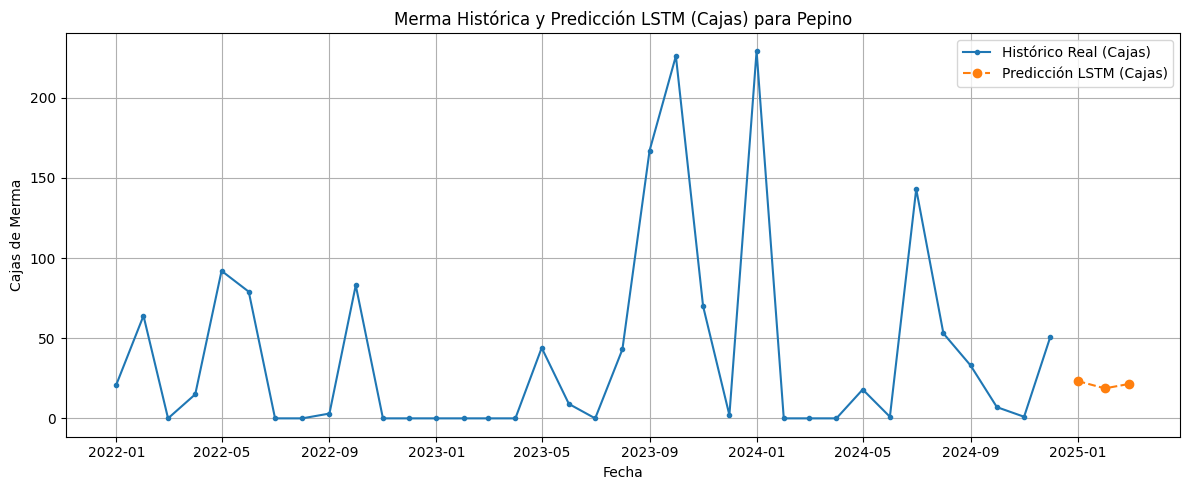


--- Fin del Script LSTM ---


In [ ]:
# -*- coding: utf-8 -*-
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Imports para Redes Neuronales (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Imports para preprocesamiento
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split # Para dividir datos de entrenamiento/validación

# Ignorar advertencias comunes (opcional)
import warnings
warnings.filterwarnings("ignore")

# --- 1. Cargar y Preprocesar Datos (Reutilizado) ---
file_name = "merma_bod_combinado_2022-2024.csv"
df = pd.read_csv(file_name)
month_map = { 'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12 }
df['Month_Num'] = df['Month'].map(month_map)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int)
df = df[df['Month_Num'] != 0]
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- 2. Definir Datos de Temperatura (Reutilizado) ---
temp_f = { 1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85, 7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61 }
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}
temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])

# --- 3. Preparar Datos Base para Modelado (Cajas) ---
df_product_monthly = df.groupby(['Date', 'Producto'])['Cajas'].sum().reset_index()
all_products = df_product_monthly['Producto'].unique()
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, all_products], names=['Date', 'Producto'])
df_model_base = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()
df_model_base['Month_Num'] = df_model_base['Date'].dt.month
df_model_base = pd.merge(df_model_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')
df_model_base = df_model_base.rename(columns={'Date': 'ds', 'Cajas': 'y'})
df_model_base = df_model_base.sort_values(by=['Producto', 'ds'])

# --- 4. Seleccionar Productos y Preparación Específica para LSTM ---

# Usar los top N productos (puedes ajustar N)
top_n = 5 # Reducimos N para que el ejemplo sea más rápido
total_spoilage_cajas = df_model_base.groupby('Producto')['y'].sum().sort_values(ascending=False)
top_products = total_spoilage_cajas.head(top_n).index.tolist()
print(f"Preparando datos LSTM para los siguientes {top_n} productos: {', '.join(top_products)}")

# Parámetros LSTM
n_steps_in = 12  # Usar los últimos 12 meses como secuencia de entrada
n_features = 2 # Usaremos 2 características: Merma (y) y Temperatura (temp)
n_steps_out = 3  # Predecir los próximos 3 meses

# Diccionarios para guardar modelos, scalers y predicciones
models_lstm = {}
scalers_features = {}
scalers_target = {}
predictions_lstm = {}

# Función para crear secuencias
def create_sequences(data_features, data_target, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data_features)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data_features):
            break
        seq_x = data_features[i:end_ix, :]
        seq_y = data_target[end_ix:out_end_ix] # Predecir los siguientes n_steps_out
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# --- 5. Bucle por Producto: Escalar, Crear Secuencias, Entrenar ---
for product in top_products:
    print(f"\n--- Procesando Producto: {product} ---")
    start_prod = time.time()

    product_data = df_model_base[df_model_base['Producto'] == product][['ds', 'y', 'temp']].copy()
    product_data = product_data.set_index('ds')

    # Verificar si hay suficientes datos
    if len(product_data) < n_steps_in + n_steps_out:
        print(f"  * Datos insuficientes (< {n_steps_in + n_steps_out}) para crear secuencias en {product}. Saltando...")
        continue

    # Seleccionar features (y, temp)
    features_data = product_data[['y', 'temp']].values

    # Escalar características entre 0 y 1 (IMPORTANTE para LSTMs)
    scaler_f = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_f.fit_transform(features_data)
    scalers_features[product] = scaler_f # Guardar scaler de features

    # Escalar solo el target (y) por separado para poder invertir la predicción
    scaler_t = MinMaxScaler(feature_range=(0, 1))
    scaled_target = scaler_t.fit_transform(features_data[:, 0].reshape(-1, 1)) # Escalar solo 'y'
    scalers_target[product] = scaler_t # Guardar scaler de target

    # Crear secuencias
    # Usamos scaled_features como entrada, scaled_target como salida
    X_seq, y_seq = create_sequences(scaled_features, scaled_target.flatten(), n_steps_in, n_steps_out)

    if X_seq.shape[0] == 0: # Verificar si se crearon secuencias
         print(f"  * No se pudieron crear secuencias para {product}. Saltando...")
         continue

    print(f"  * Datos preparados: X_seq shape={X_seq.shape}, y_seq shape={y_seq.shape}")

    # Dividir en entrenamiento y validación (ej. últimos 6 meses para validar)
    n_val_samples = min(6, int(len(X_seq) * 0.2)) # Usar hasta 6 meses o 20% para validación
    if n_val_samples < 1:
         print(f"  * No hay suficientes muestras para validación en {product}. Entrenando sin validación.")
         X_train, y_train = X_seq, y_seq
         X_val, y_val = None, None # No hay validación
    else:
        X_train, y_train = X_seq[:-n_val_samples], y_seq[:-n_val_samples]
        X_val, y_val = X_seq[-n_val_samples:], y_seq[-n_val_samples:]
        print(f"  * División: {len(X_train)} entrenamiento, {len(X_val)} validación.")

    # --- Definir Modelo LSTM ---
    # (Arquitectura simple, puede requerir ajuste)
    model = Sequential([
        Input(shape=(n_steps_in, n_features)), # Capa de entrada explícita
        LSTM(units=50, activation='relu', return_sequences=False), # 50 unidades LSTM
        # LSTM(units=50, activation='relu'), # Puedes apilar más capas LSTM
        Dense(units=n_steps_out) # Capa de salida para predecir n_steps_out valores
    ])

    # Compilar modelo
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mse') # Mean Squared Error

    # Callback para Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss' if X_val is not None else 'loss', patience=10, restore_best_weights=True)

    # --- Entrenar Modelo ---
    print("  * Entrenando modelo LSTM...")
    history = model.fit(
        X_train, y_train,
        epochs=100, # Número máximo de épocas
        batch_size=8, # Tamaño del lote
        validation_data=(X_val, y_val) if X_val is not None else None,
        callbacks=[early_stopping],
        verbose=0 # 0 para no mostrar progreso por época, 1 para mostrar
    )
    print("  * Entrenamiento completado.")
    models_lstm[product] = model

    # --- Generar Predicción Futura (Multi-Step Recursiva) ---
    # Tomar la última secuencia de datos históricos escalados
    last_sequence_features = scaled_features[-n_steps_in:]
    current_sequence = last_sequence_features.reshape((1, n_steps_in, n_features))

    # Predecir el siguiente paso
    next_step_pred_scaled = model.predict(current_sequence, verbose=0)[0] # Predicción para los próximos n_steps_out

    # Invertir escala de la predicción
    next_step_pred = scalers_target[product].inverse_transform(next_step_pred_scaled.reshape(-1, 1)).flatten()

    # Guardar predicción
    predictions_lstm[product] = next_step_pred
    end_prod = time.time()
    print(f"  * Procesamiento completo para {product} ({end_prod - start_prod:.2f} seg)")


# --- 6. Mostrar Resultados ---
print("\n--- Predicciones de Merma (Cajas) con LSTM (Próximos 3 Meses) ---")

# Crear fechas futuras
last_hist_date = df_model_base['ds'].max()
future_dates_pred = pd.date_range(start=last_hist_date + pd.DateOffset(months=1), periods=n_steps_out, freq='MS')

results_lstm_list = []
for product, preds in predictions_lstm.items():
    temp_res = pd.DataFrame({'Fecha': future_dates_pred, 'Producto': product, 'Prediccion_Cajas': preds})
    results_lstm_list.append(temp_res)

if results_lstm_list:
    final_results_lstm = pd.concat(results_lstm_list)
    # Asegurar que predicciones no sean negativas
    final_results_lstm['Prediccion_Cajas'] = final_results_lstm['Prediccion_Cajas'].clip(lower=0)
    # Redondear si se desea
    # final_results_lstm['Prediccion_Cajas'] = np.round(final_results_lstm['Prediccion_Cajas'])
    print(final_results_lstm.to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("No se generaron predicciones LSTM.")

# (Opcional) Graficar
print("\n--- Graficando Predicciones LSTM (Ejemplo) ---")
products_to_plot_lstm = list(predictions_lstm.keys())[:3]

for product in products_to_plot_lstm:
     if product in models_lstm: # Solo graficar si se entrenó modelo
        plt.figure(figsize=(12, 5))
        # Histórico
        hist_data = df_model_base[df_model_base['Producto'] == product]
        plt.plot(hist_data['ds'], hist_data['y'], label='Histórico Real (Cajas)', marker='.', linestyle='-')
        # Predicción
        pred_data = pd.DataFrame({'ds': future_dates_pred, 'Prediccion_Cajas': predictions_lstm[product]})
        plt.plot(pred_data['ds'], pred_data['Prediccion_Cajas'], label='Predicción LSTM (Cajas)', marker='o', linestyle='--')
        plt.title(f'Merma Histórica y Predicción LSTM (Cajas) para {product}')
        plt.xlabel('Fecha')
        plt.ylabel('Cajas de Merma')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print("\n--- Fin del Script LSTM ---")

--- Cargando y Preprocesando Datos ---
--- Preparando Datos Base ---
--- Iniciando Ingeniería de Características para TabTransformer ---
--- Ingeniería de Características Completa (0.03 seg) ---
--- Escalando Características Continuas ---
--- Definiendo Arquitectura TabTransformer ---

--- Iniciando Entrenamiento con Validación Cruzada Temporal ---
ADVERTENCIA: Este proceso puede ser LENTO...

--- Fold 1/100 ---
  Fold 1 - Mejor val_loss: 0.0751
  * Nuevo mejor modelo encontrado en fold 1!

--- Fold 2/100 ---
  Fold 2 - Mejor val_loss: 0.1492

--- Fold 3/100 ---
  Fold 3 - Mejor val_loss: 0.1450

--- Fold 4/100 ---
  Fold 4 - Mejor val_loss: 63.0399

--- Fold 5/100 ---
  Fold 5 - Mejor val_loss: 183.2459

--- Fold 6/100 ---
  Fold 6 - Mejor val_loss: 89.7154

--- Fold 7/100 ---
  Fold 7 - Mejor val_loss: 198.1482

--- Fold 8/100 ---
  Fold 8 - Mejor val_loss: 36.6745

--- Fold 9/100 ---
  Fold 9 - Mejor val_loss: 0.4169

--- Fold 10/100 ---
  Fold 10 - Mejor val_loss: 3.3818

--- Fold 

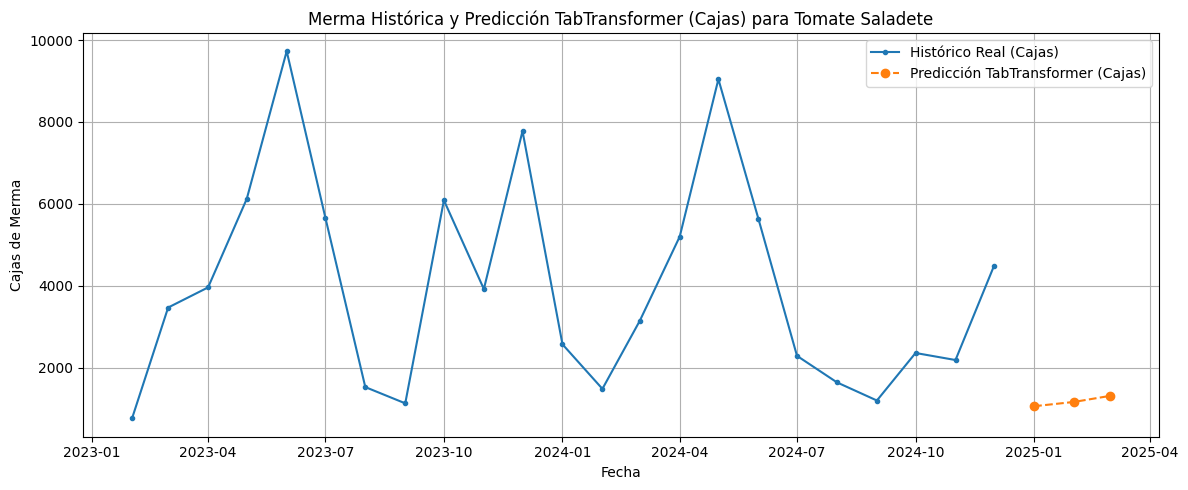

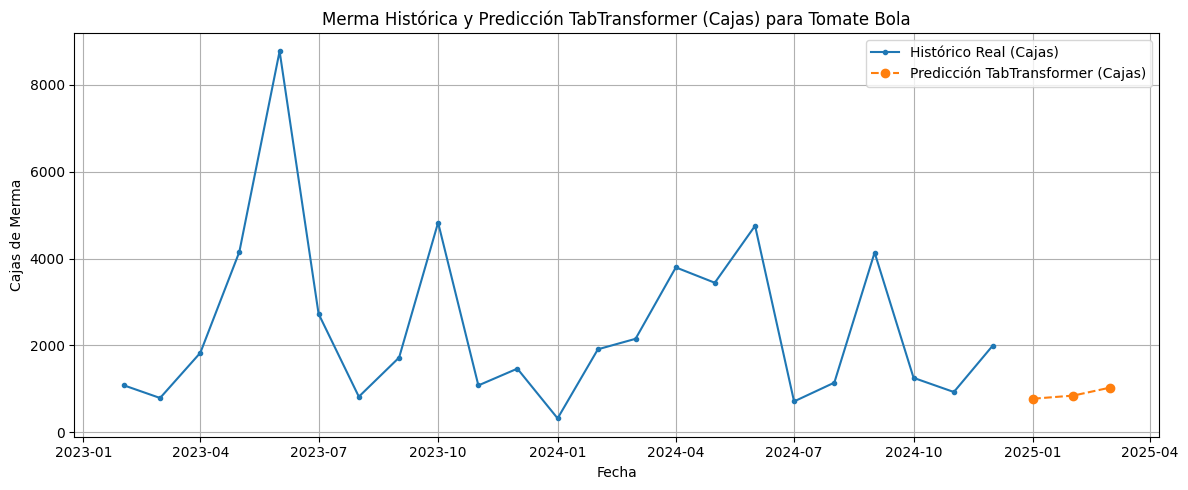

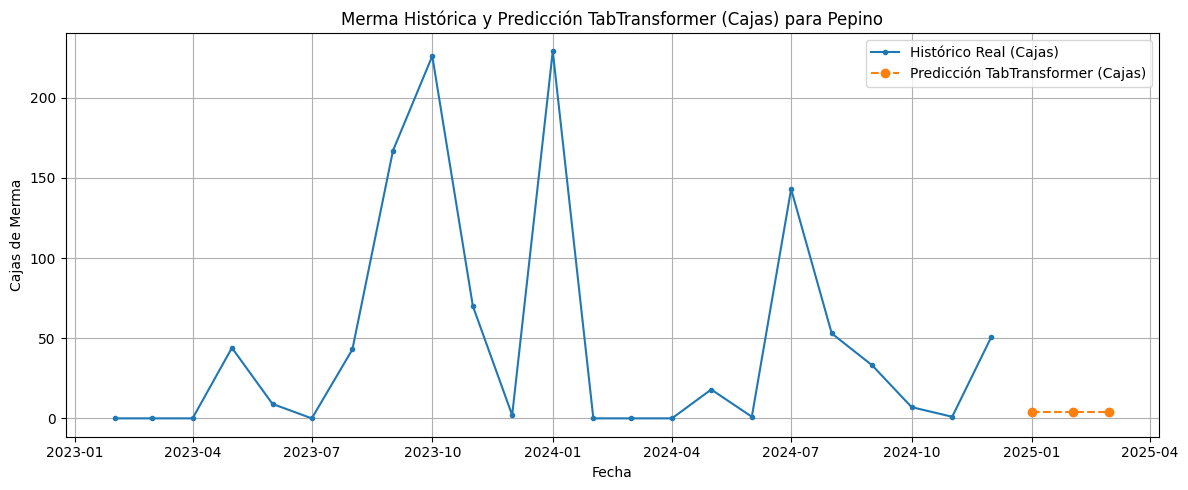


--- Fin del Script TabTransformer ---


In [30]:
# -*- coding: utf-8 -*-
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Imports para Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

# Imports para Redes Neuronales (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, MultiHeadAttention, LayerNormalization,
                                     Dense, Dropout, Concatenate, Flatten, Reshape, # Añadido Reshape
                                     GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Ignorar advertencias comunes (opcional)
import warnings
warnings.filterwarnings("ignore")

# --- 1. Cargar y Preprocesar Datos ---
print("--- Cargando y Preprocesando Datos ---")
file_name = "merma_bod_combinado_2022-2024.csv"
df = pd.read_csv(file_name)
month_map = { 'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12 }
df['Month_Num'] = df['Month'].map(month_map)
df['Month_Num'] = df['Month_Num'].fillna(0).astype(int)
df = df[df['Month_Num'] != 0]
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

# --- 2. Definir Datos de Temperatura ---
temp_f = { 1: 60, 2: 65, 3: 71, 4: 77, 5: 82, 6: 85, 7: 86, 8: 86, 9: 81, 10: 75, 11: 67, 12: 61 }
temp_c = {month: round((f - 32) * 5/9, 1) for month, f in temp_f.items()}
temp_df = pd.DataFrame(list(temp_c.items()), columns=['Month_Num', 'Temp_C_Avg_Hist'])

# --- 3. Preparar Datos Base para Modelado (Cajas) ---
print("--- Preparando Datos Base ---")
df_product_monthly = df.groupby(['Date', 'Producto'])['Cajas'].sum().reset_index()
all_products = df_product_monthly['Producto'].unique()
n_unique_products = len(all_products)
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
multi_index = pd.MultiIndex.from_product([all_dates, all_products], names=['Date', 'Producto'])
df_model_base = df_product_monthly.set_index(['Date', 'Producto']).reindex(multi_index, fill_value=0.0).reset_index()
df_model_base['Month_Num'] = df_model_base['Date'].dt.month
df_model_base = pd.merge(df_model_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')
df_model_base = df_model_base.rename(columns={'Date': 'ds', 'Cajas': 'y'})
df_model_base = df_model_base.sort_values(by=['Producto', 'ds'])

# --- 4. Ingeniería de Características (Incluyendo Sin/Cos) ---
print("--- Iniciando Ingeniería de Características para TabTransformer ---")
start_fe = time.time()
df_model_base['month'] = df_model_base['ds'].dt.month
df_model_base['year'] = df_model_base['ds'].dt.year
df_model_base['month_sin'] = np.sin(2 * np.pi * df_model_base['month']/12.0)
df_model_base['month_cos'] = np.cos(2 * np.pi * df_model_base['month']/12.0)
lags = [1, 2, 3, 12, 13]
for lag in lags: df_model_base[f'y_lag_{lag}'] = df_model_base.groupby('Producto')['y'].shift(lag)
windows = [3, 6, 12]
for window in windows:
    df_model_base[f'y_roll_mean_{window}'] = df_model_base.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).mean()
    df_model_base[f'y_roll_std_{window}'] = df_model_base.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).std()
le = LabelEncoder()
df_model_base['producto_encoded'] = le.fit_transform(df_model_base['Producto'])
producto_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df_model_ready = df_model_base.dropna(subset=[col for col in df_model_base.columns if 'lag' in col or 'roll' in col])
# Rellenar NaNs en std dev que pueden quedar al inicio
std_cols = [col for col in df_model_ready.columns if 'roll_std' in col]
df_model_ready[std_cols] = df_model_ready[std_cols].fillna(0)
end_fe = time.time()
print(f"--- Ingeniería de Características Completa ({end_fe - start_fe:.2f} seg) ---")

# --- 5. Separar Features Categóricas y Continuas ---
categorical_features = ['producto_encoded']
continuous_features = [
    'year', 'month_sin', 'month_cos', 'temp',
] + [col for col in df_model_ready.columns if 'lag' in col or 'roll' in col]
target = 'y'

# --- 6. Escalar Features Continuas ---
print("--- Escalando Características Continuas ---")
scaler_cont = MinMaxScaler()
X_cont_scaled = scaler_cont.fit_transform(df_model_ready[continuous_features])
X_cat = df_model_ready[categorical_features].values
X_cont = X_cont_scaled
y = df_model_ready[target].values

# --- 7. Definir Arquitectura TabTransformer (Corregida) ---
print("--- Definiendo Arquitectura TabTransformer ---")
# Hiperparámetros (¡Necesitan ajuste!)
embedding_dim = 16
num_heads = 4
ff_dim = 32
num_transformer_blocks = 2
mlp_units = [64, 32]
dropout_rate = 0.1

# Inputs
input_cat = Input(shape=(len(categorical_features),), name='input_categorical')
input_cont = Input(shape=(len(continuous_features),), name='input_continuous')

# --- Rama Categórica ---
cat_embeddings = Embedding(input_dim=n_unique_products, output_dim=embedding_dim, name='product_embedding')(input_cat[:, 0])
# CORRECCIÓN: Usar Reshape en lugar de tf.expand_dims
cat_embeddings_reshaped = Reshape((1, embedding_dim), name='reshape_embeddings')(cat_embeddings)

# Bloques Transformer
transformer_output = cat_embeddings_reshaped # Usar la salida reshaped
for i in range(num_transformer_blocks):
    # Atención
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, name=f'mha_{i}')(transformer_output, transformer_output)
    # Conexión Residual y Normalización
    x = LayerNormalization(epsilon=1e-6, name=f'ln1_{i}')(transformer_output + attention_output)
    # Feed Forward
    ff_output = Dense(ff_dim, activation="relu", name=f'ff1_{i}')(x)
    ff_output = Dropout(dropout_rate, name=f'drop1_{i}')(ff_output)
    ff_output = Dense(embedding_dim, name=f'ff2_{i}')(ff_output)
     # Conexión Residual y Normalización
    transformer_output = LayerNormalization(epsilon=1e-6, name=f'ln2_{i}')(x + ff_output)

processed_cat = GlobalAveragePooling1D(name='gap_cat')(transformer_output)

# --- Rama Continua ---
processed_cont = LayerNormalization(epsilon=1e-6, name='ln_cont')(input_cont)

# --- Concatenar y MLP Final ---
concatenated = Concatenate(name='concatenate')([processed_cat, processed_cont])
x = Dropout(dropout_rate, name='drop_concat')(concatenated)
for i, units in enumerate(mlp_units):
    x = Dense(units, activation="relu", name=f'mlp_{i}')(x)
    x = Dropout(dropout_rate, name=f'drop_mlp_{i}')(x)
output = Dense(1, activation="linear", name='output')(x)

# Crear el Modelo
tabtransformer_model = Model(inputs=[input_cat, input_cont], outputs=output)

# Compilar
tabtransformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
# tabtransformer_model.summary() # Descomentar para ver resumen

# --- 8. Validación Cruzada Temporal y Entrenamiento ---
print("\n--- Iniciando Entrenamiento con Validación Cruzada Temporal ---")
print("ADVERTENCIA: Este proceso puede ser LENTO...")
start_train_cv = time.time()
n_splits = 100
tscv = TimeSeriesSplit(n_splits=n_splits)
fold = 0
histories = []
best_val_loss = float('inf')
best_model_weights = None

for train_index, val_index in tscv.split(X_cont):
    fold += 1
    print(f"\n--- Fold {fold}/{n_splits} ---")
    X_cat_train, X_cat_val = X_cat[train_index], X_cat[val_index]
    X_cont_train, X_cont_val = X_cont[train_index], X_cont[val_index]
    y_train, y_val = y[train_index], y[val_index]
    X_train_dict = {'input_categorical': X_cat_train, 'input_continuous': X_cont_train}
    X_val_dict = {'input_categorical': X_cat_val, 'input_continuous': X_cont_val}
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    # Recompilar para reiniciar optimizador (opcional)
    tabtransformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    history = tabtransformer_model.fit(
        X_train_dict, y_train,
        epochs=150, batch_size=128,
        validation_data=(X_val_dict, y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    histories.append(history)
    current_best_val_loss = min(history.history['val_loss'])
    print(f"  Fold {fold} - Mejor val_loss: {current_best_val_loss:.4f}")
    if current_best_val_loss < best_val_loss:
        best_val_loss = current_best_val_loss
        best_model_weights = tabtransformer_model.get_weights()
        print(f"  * Nuevo mejor modelo encontrado en fold {fold}!")
end_train_cv = time.time()
print(f"--- Entrenamiento CV Completo ({end_train_cv - start_train_cv:.2f} seg) ---")

# --- 9. Entrenar Modelo Final con Todos los Datos ---
print("\n--- Entrenando Modelo TabTransformer Final con Todos los Datos ---")
start_train_final = time.time()
if best_model_weights:
     print("  * Cargando mejores pesos encontrados durante CV.")
     tabtransformer_model.set_weights(best_model_weights)
     final_epochs = 2000
     final_lr = 0.001
     print(f"  * Re-entrenando {final_epochs} épocas adicionales con todos los datos (LR={final_lr})...")
     tabtransformer_model.compile(optimizer=Adam(learning_rate=final_lr), loss='mse', metrics=['mae'])
     tabtransformer_model.fit(
         {'input_categorical': X_cat, 'input_continuous': X_cont}, y,
         epochs=final_epochs, batch_size=64, verbose=0
     )
else:
     print("  * No se encontraron pesos óptimos en CV, entrenando desde cero.")
     tabtransformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
     tabtransformer_model.fit(
        {'input_categorical': X_cat, 'input_continuous': X_cont}, y,
        epochs=100, batch_size=64, verbose=0
     )
end_train_final = time.time()
print(f"--- Entrenamiento Final Completo ({end_train_final - start_train_final:.2f} seg) ---")

# --- 10. Preparar Datos Futuros para Predicción ---
print("\n--- Preparando Datos Futuros para TabTransformer ---")
n_forecast_periods = 3
last_hist_date = df_model_base['ds'].max()
future_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1), periods=n_forecast_periods, freq='MS')
future_df_list = []
unique_prod_encoded = df_model_base['producto_encoded'].unique()
for prod_encoded in unique_prod_encoded:
    prod_name = le.inverse_transform([prod_encoded])[0]
    temp_df_future = pd.DataFrame({'ds': future_dates, 'producto_encoded': prod_encoded, 'Producto': prod_name})
    future_df_list.append(temp_df_future)
future_data_base = pd.concat(future_df_list).sort_values(by=['producto_encoded', 'ds']).reset_index(drop=True)
future_data_base['Month_Num'] = future_data_base['ds'].dt.month
future_data_base = pd.merge(future_data_base, temp_df.rename(columns={'Temp_C_Avg_Hist': 'temp'}), on='Month_Num', how='left')
future_data_base['month'] = future_data_base['ds'].dt.month
future_data_base['year'] = future_data_base['ds'].dt.year
future_data_base['month_sin'] = np.sin(2 * np.pi * future_data_base['month']/12.0)
future_data_base['month_cos'] = np.cos(2 * np.pi * future_data_base['month']/12.0)
df_for_future_features = pd.concat([df_model_base, future_data_base], ignore_index=True).sort_values(by=['Producto', 'ds'])
for lag in lags: future_data_base[f'y_lag_{lag}'] = df_for_future_features.groupby('Producto')['y'].shift(lag).loc[future_data_base.index]
for window in windows:
    future_data_base[f'y_roll_mean_{window}'] = df_for_future_features.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).mean().loc[future_data_base.index]
    future_data_base[f'y_roll_std_{window}'] = df_for_future_features.groupby('Producto')['y'].shift(1).rolling(window=window, min_periods=1).std().loc[future_data_base.index]
future_data_base[std_cols] = future_data_base[std_cols].fillna(0) # Rellenar std dev NaNs
future_data_base = future_data_base.fillna(0) # Rellenar otros NaNs (lags iniciales)

# Separar y escalar features futuras
X_cat_future = future_data_base[categorical_features].values
X_cont_future_scaled = scaler_cont.transform(future_data_base[continuous_features]) # Usar scaler entrenado
X_future_dict = {'input_categorical': X_cat_future, 'input_continuous': X_cont_future_scaled}

# --- 11. Predecir con Modelo Final ---
print("--- Realizando Predicciones Futuras de Cajas con TabTransformer ---")
future_predictions_tab = tabtransformer_model.predict(X_future_dict)
future_predictions_tab = future_predictions_tab.flatten()
future_predictions_tab[future_predictions_tab < 0] = 0

results_df_tab = future_data_base[['ds', 'Producto']].copy()
results_df_tab['Prediccion_Cajas'] = future_predictions_tab

# --- 12. Mostrar Resultados ---
print("\n--- Predicciones de Merma (Cajas) con TabTransformer (Próximos 3 Meses) ---")
total_spoilage_cajas = df_model_base.groupby('Producto')['y'].sum().sort_values(ascending=False) # Recalcular por si acaso
top_products_cajas = total_spoilage_cajas.head(10).index.tolist()
results_df_top_n_tab = results_df_tab[results_df_tab['Producto'].isin(top_products_cajas)]
print(results_df_top_n_tab.rename(columns={'ds': 'Fecha'}).to_markdown(index=False, numalign="left", stralign="left"))

# Graficar
print("\n--- Graficando Predicciones TabTransformer (Ejemplo) ---")
products_to_plot = top_products_cajas[:3]
for product in products_to_plot:
    plt.figure(figsize=(12, 5))
    hist_data = df_model_ready[df_model_ready['Producto'] == product]
    plt.plot(hist_data['ds'], hist_data['y'], label='Histórico Real (Cajas)', marker='.', linestyle='-')
    pred_data = results_df_tab[results_df_tab['Producto'] == product]
    plt.plot(pred_data['ds'], pred_data['Prediccion_Cajas'], label='Predicción TabTransformer (Cajas)', marker='o', linestyle='--')
    plt.title(f'Merma Histórica y Predicción TabTransformer (Cajas) para {product}')
    plt.xlabel('Fecha')
    plt.ylabel('Cajas de Merma')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Fin del Script TabTransformer ---")